In [1]:
import os,sys
import datetime
import scanpy as sc
import numpy as np
import pandas as pd

In [2]:
#NO P-VALUE CORRECTION

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
from matplotlib import cm
from matplotlib.lines import Line2D
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker

## Making the figures editable in illustrator and setting params


In [4]:
import matplotlib as mpl
mpl.rc('font',family='Arial')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

## Making the interaction count heatmap

In [22]:
#uploading the interaction counts
path_interactions = 'cellphone_output/kidney_exp_cyc_epi/count_network.txt'
counts = pd.read_csv(path_interactions, header=0, sep='\t')

In [23]:
counts['log_counts'] = np.log(counts['count']+1)

In [24]:
count_mtx = pd.pivot(counts, index= 'SOURCE',columns = 'TARGET', values = 'log_counts' )

In [25]:
count_mtx.index.name = None
count_mtx.columns.name = None

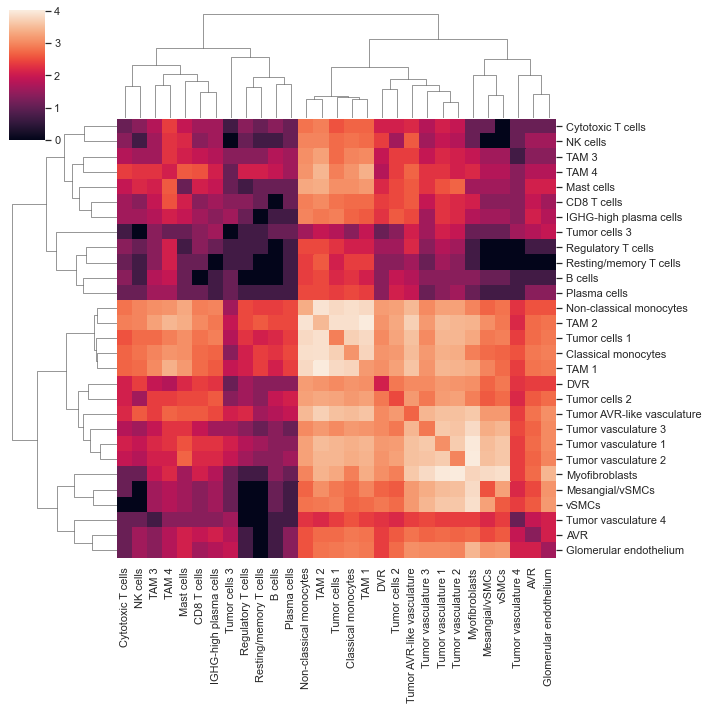

In [26]:
#lets get the hierarchical order for the columns using clustermap function
sns.set(font_scale = 1)
heatmap = sns.clustermap(count_mtx, figsize = (10, 10))
heatmap

In [27]:
#let's take the hierarchically ordered indexes
order_ix = heatmap.dendrogram_row.reordered_ind
column_list=count_mtx.columns.to_list()
column_list = [column_list[i] for i in order_ix]
count_mtx_ordered = count_mtx[column_list]
count_mtx_ordered = count_mtx_ordered.T[column_list] #since it symmetrical we can order this way

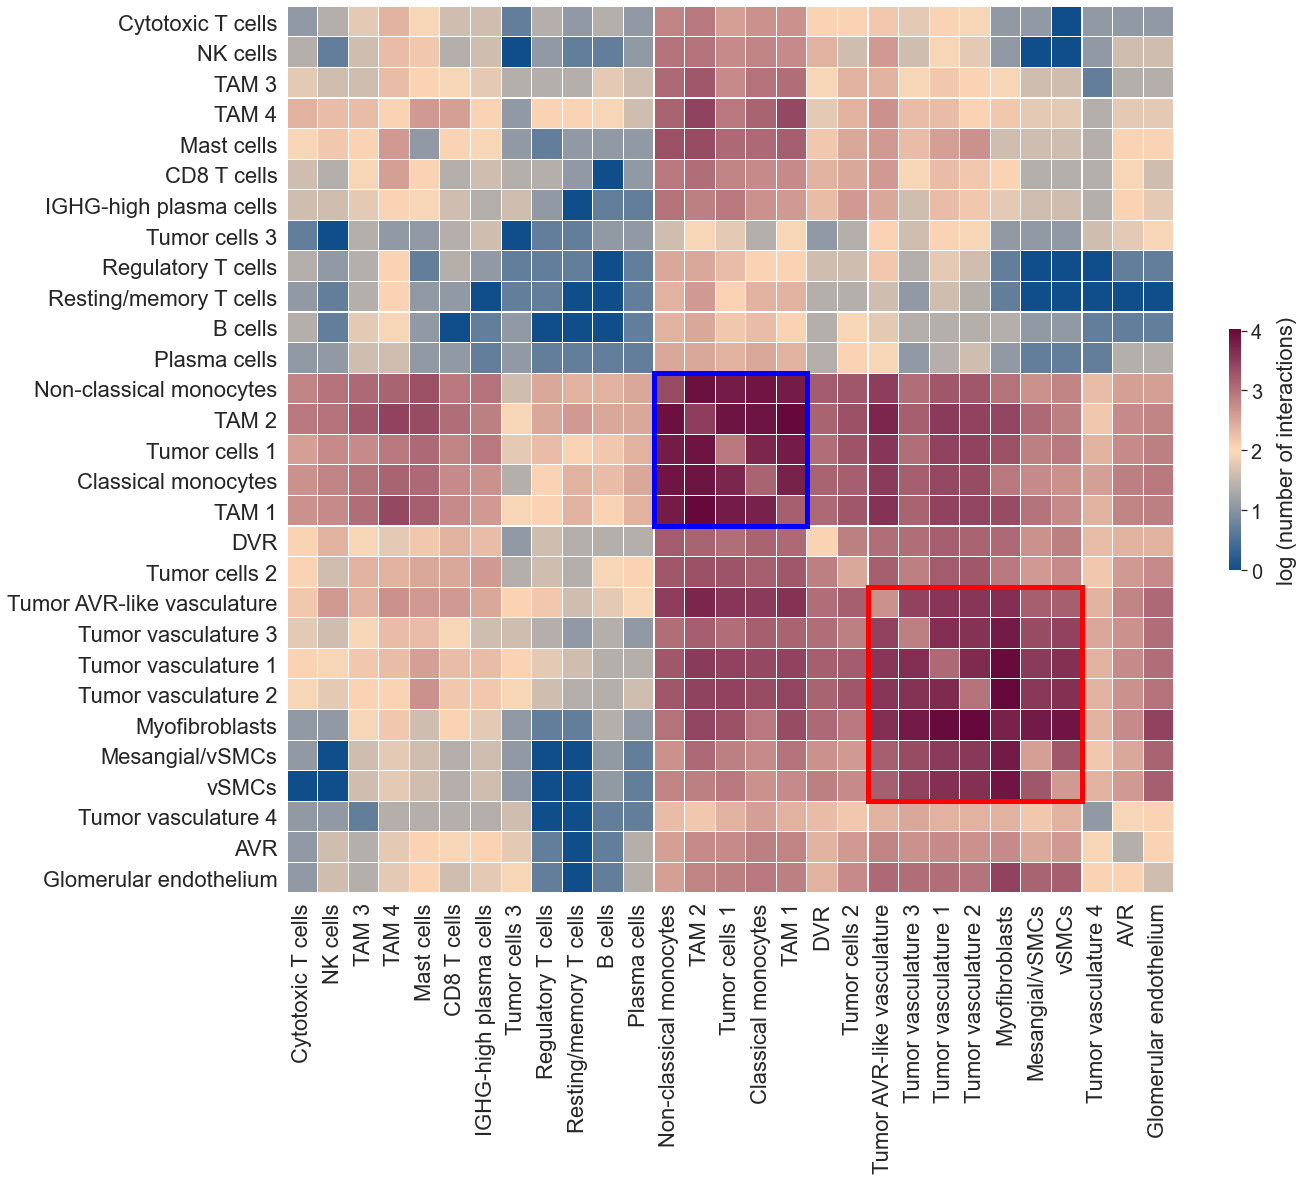

In [35]:
#plotting the count matrix

f, ax = plt.subplots(1, 1, figsize=(20,20))

#choosing the colormap
from matplotlib.colors import LinearSegmentedColormap
color = LinearSegmentedColormap.from_list(
    name='cmap', 
    colors=['#104e8b', #blue
            '#ffdab9', #peach
            '#66083b' #dark-red
           ])
sns.set(font_scale = 2)
heatmap = sns.heatmap(count_mtx_ordered, annot=False,
            linewidths=0.1,square=True,  ax=ax, cbar = True, 
                      cmap = color,
                     cbar_kws={ 'orientation':'vertical', 
                              'shrink' : 0.2})

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('log (number of interactions)', fontsize =22)

#making a square to highlight interactions of interest
ax.add_patch(
     patches.Rectangle(
         (12, 12), #x, y coordinate
         5.0, #width
         5.0, #height
         edgecolor='blue',
         fill=False,
         lw=5
     ) )

#another one
ax.add_patch(
     patches.Rectangle(
         (19, 19), #x, y coordinate
         7.0, #width
         7.0, #height
         edgecolor='red',
         fill=False,
         lw=5
     ) )
plt.tight_layout()
plt.savefig('figures_paper/cellphone_count_map.png', dpi=400)

## Exploring CellPhoneDB results

First, I made massive plots of all the singificant interactions to investigate which ones could be highlighted in the main figures and made a notes file that I will be uploading here to plot the desired interactions.

In [11]:
#simple plotting function for dotplot that can be used for initial exploration

def plot_cpdb_dotplot(data, figsize =(20, 4), log_p=True):
    sns.color_palette("magma", as_cmap=True)
    mpl.rcParams['axes.grid'] = False
    mpl.rcParams['legend.frameon'] = False
    fig, ax = plt.subplots(figsize=figsize)
    sns.scatterplot(x=data.index, y=data['pair'], 
                size=-(data['pvalue']), sizes = (100, 300), 
                hue=np.log2(data["mean"]), data=data, palette='magma')
    plt.setp(ax.get_xticklabels(), rotation=90)
    
    mpl.rcParams['legend.loc'] = 'upper center'
    plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
    plt.show()
                           
                           
   

## Making and annotating dotplots for selected interactions

In [118]:
means_path = 'cellphone_output/kidney_exp_cyc_epi/means.txt'
pvalues_path = 'cellphone_output/kidney_exp_cyc_epi/pvalues.txt'

means = pd.read_csv(means_path, header=0, sep='\t', index_col=False)
pvalues = pd.read_csv(pvalues_path, header=0, sep='\t', index_col=False)

In [119]:
#making a mask to select only significant interactions
df_for_mask = pvalues

#droping the columns that contain non-numerical data
df_for_mask = df_for_mask.drop(df_for_mask.columns[list(range(0, 11, 1))], axis=1)


In [120]:
# extracting the cell-type pair names
pairs = []
for i in df_for_mask.columns:
    pairs.append(i)
    

In [121]:
#making a dict: for each cell type pair record the interaction, pval and mean
#next we can concatenate the dataframes for one big dotplot or plot separately as all df contain pvals and means

#note: this time keeping all interactions and not selecting only the significant ones

df_dict_pairs = {}

pval_df = pvalues.set_index('interacting_pair') 
mean_df= means.set_index('interacting_pair') 
for i in pairs:
    mask = pval_df[i]<0.05
    df= pd.DataFrame()
    df['pvalue'] =pval_df[i]
    df['mean'] = mean_df[i]
    df['pair'] = i
    df_dict_pairs[i] = df
    

In [122]:
#optional: making a list of dataframes to concatenate for one big dotplot
df_list =[]
for key, value in df_dict_pairs.items():
    df_list.append(value)

In [123]:
#concatenate
all_dataframes= pd.concat(df_list)

In [124]:
#add a pseudovalue of 1-e6 to the p-value to avoid the zeros
#store -log10 pvalue in all_dataframes
all_dataframes['-log10 p-value'] = -(np.log10(all_dataframes['pvalue']+1e-6))

In [125]:
#add a pseudovalue of 1 to mean to avoid division by zero later on
#log2 of 1 is 0, so it will not change anything
pseudo = 1
all_dataframes['mean'] = all_dataframes['mean']+pseudo

In [126]:
#make lists of receptors and ligands separately for selection purposes
interacting_pair= all_dataframes.index.tolist()
partner_a_list = []
partner_b_list = []
for i in interacting_pair:
    pair = i.split("_")
    partner_a_list.append(pair[0])
    partner_b_list.append(pair[1])

In [127]:
#make lists of interacting cell types for selection purposes
type_a_list = []
type_b_list = []
for i in all_dataframes['pair']:
    pair = i.split("|")
    type_a_list.append(pair[0])
    type_b_list.append(pair[1])

In [128]:
#put all that into all_dataframes for easy access
all_dataframes['partner_a'] = partner_a_list
all_dataframes['partner_b'] = partner_b_list
all_dataframes['type_a'] = type_a_list
all_dataframes['type_b'] = type_b_list

In [204]:
#load spreadsheet of selected interactions to plot
path = '/Users/justina/Documents/mokslai/LAB/inkstai/our_kidney_paper_2022/interaction_summary.xlsx'
selected_interactions = pd.read_excel(path, skiprows=2)

In [205]:
selected_interactions

Unnamed: 0 Partner a     Partner b Compartment a  \
0                      adhesion       FN1  a4b1 complex       Stromal   
1             immune suppresion     ANXA1          FPR1       Stromal   
2             immune suppresion     ANXA1          FPR3       Stromal   
3    proliferation and survival      NRP1         VEGFB       Stromal   
4                  angiogenesis      NRP1         VEGFA       Stromal   
..                          ...       ...           ...           ...   
123                angiogenesis      NRP1         VEGFA   Endothelial   
124                angiogenesis      NRP2         VEGFA   Endothelial   
125                angiogenesis      NRP1         VEGFB   Endothelial   
126                angiogenesis      FLT1         VEGFB   Endothelial   
127                       other    CMKLR1       RARRES2   Endothelial   

    Compartment b                                       Cell types a  \
0          Immune             Mesangial/vSMCs, Myofibroblasts, vSMCs   
1          Immune             Mesangial/vSMCs, Myofibroblasts, vSMCs   
2          Immune             Mesangial/vSMCs, Myofibroblasts, vSMCs   
3          Immune             Mesangial/vSMCs, Myofibroblasts, vSMCs   
4          Immune             Mesangial/vSMCs, Myofibroblasts, vSMCs   
..            ...                                                ...   
123         Tumor  Tumor AVR-like vasculature, Tumor vasculature ...   
124         Tumor    Tumor AVR-like vasculature, Tumor vasculature 1   
125         Tumor  Tumor AVR-like vasculature, Tumor vasculature ...   
126         Tumor  Tumor AVR-like vasculature, Tumor vasculature ...   
127         Tumor                         Tumor AVR-like vasculature   

                                          Cell types b  ref  
0                                          CD8 T cells  NaN  
1    Classical monocytes, Non-classical monocytes, ...  NaN  
2                                         TAM 1, TAM 2  NaN  
3                                                TAM 2  NaN  
4                           Classical monocytes, TAM 1  NaN  
..                                                 ...  ...  
123        Tumor cells 1, Tumor cells 2, Tumor cells 3  NaN  
124        Tumor cells 1, Tumor cells 2, Tumor cells 3  NaN  
125                       Tumor cells 1, Tumor cells 2  NaN  
126                       Tumor cells 1, Tumor cells 2  NaN  
127        Tumor cells 1, Tumor cells 2, Tumor cells 3  NaN  

[128 rows x 8 columns]

### Tumor - immune interactions (and vice versa)

In [206]:
#select the compartments of interest
mask_for_int1 = selected_interactions['Compartment a'].isin(['Immune'])&selected_interactions['Compartment b'].isin(['Tumor'])
mask_for_int2 = selected_interactions['Compartment a'].isin(['Tumor'])&selected_interactions['Compartment b'].isin(['Immune'])


index_list = list(np.where(mask_for_int2)[0])+list(np.where(mask_for_int1)[0])
com_tum_imm = selected_interactions.iloc[index_list]

In [207]:
all_dataframes['type_b'].unique()

array(['AVR', 'B cells', 'CD8 T cells', 'Classical monocytes',
       'Cytotoxic T cells', 'DVR', 'Glomerular endothelium',
       'IGHG-high plasma cells', 'Mast cells', 'Mesangial/vSMCs',
       'Myofibroblasts', 'NK cells', 'Non-classical monocytes',
       'Plasma cells', 'Regulatory T cells', 'Resting/memory T cells',
       'TAM 1', 'TAM 2', 'TAM 3', 'TAM 4', 'Tumor AVR-like vasculature',
       'Tumor cells 1', 'Tumor cells 2', 'Tumor cells 3',
       'Tumor vasculature 1', 'Tumor vasculature 2',
       'Tumor vasculature 3', 'Tumor vasculature 4', 'vSMCs'],
      dtype=object)

In [208]:
#select the cell types
type_a=[ 'CD8 T cells', 'Classical monocytes',
       'Cytotoxic T cells',
       'NK cells', 'Non-classical monocytes',
      'Regulatory T cells', 'Resting/memory T cells',
       'TAM 1', 'TAM 2', 'TAM 3', 'TAM 4', 'Tumor cells 1', 'Tumor cells 2', 'Tumor cells 3']

In [209]:
type_b=['CD8 T cells', 'Classical monocytes',
       'Cytotoxic T cells',
       'NK cells', 'Non-classical monocytes',
      'Regulatory T cells', 'Resting/memory T cells',
       'TAM 1', 'TAM 2', 'TAM 3', 'TAM 4', 'Tumor cells 1', 'Tumor cells 2', 'Tumor cells 3']

In [210]:
partner_a_sec = com_tum_imm['Partner a'].to_list()

In [211]:
partner_b_sec = com_tum_imm['Partner b'].to_list()

In [212]:
int_pairs = []
for i in range(len(partner_a_sec)):
    pair = partner_a_sec[i] + '_'+partner_b_sec[i]
    int_pairs.append(pair)

In [213]:
#select the data from all_dataframes

imm_tum_int = all_dataframes.loc[all_dataframes['type_a'].isin(type_a)
                              &all_dataframes['type_b'].isin(type_b)]
imm_tum_int = imm_tum_int.loc[int_pairs]

In [214]:
#remove non-relevant interactions
list_of_pairs = list(set(list(imm_tum_int['pair'])))
list_of_pairs

['TAM 2|Tumor cells 2',
 'TAM 4|Cytotoxic T cells',
 'CD8 T cells|Tumor cells 1',
 'TAM 4|Tumor cells 2',
 'Tumor cells 2|Classical monocytes',
 'Tumor cells 3|TAM 2',
 'Classical monocytes|Tumor cells 3',
 'Resting/memory T cells|Resting/memory T cells',
 'NK cells|TAM 2',
 'Non-classical monocytes|Regulatory T cells',
 'Resting/memory T cells|TAM 4',
 'Cytotoxic T cells|Regulatory T cells',
 'Classical monocytes|Resting/memory T cells',
 'Cytotoxic T cells|TAM 1',
 'TAM 1|TAM 1',
 'Resting/memory T cells|CD8 T cells',
 'CD8 T cells|TAM 4',
 'TAM 3|Tumor cells 2',
 'Resting/memory T cells|Tumor cells 2',
 'TAM 2|Tumor cells 1',
 'Tumor cells 3|Non-classical monocytes',
 'CD8 T cells|Resting/memory T cells',
 'TAM 2|Classical monocytes',
 'Tumor cells 3|Tumor cells 2',
 'Tumor cells 1|Classical monocytes',
 'TAM 1|TAM 2',
 'Tumor cells 3|TAM 1',
 'TAM 2|TAM 3',
 'Classical monocytes|CD8 T cells',
 'TAM 3|Tumor cells 3',
 'TAM 4|Non-classical monocytes',
 'Tumor cells 3|Regulatory T cel

In [215]:
list_of_pairs = [
'TAM 2|Tumor cells 2',
 'CD8 T cells|Tumor cells 1',
 'TAM 4|Tumor cells 2',
 'Tumor cells 2|Classical monocytes',
 'Tumor cells 3|TAM 2',
 'Classical monocytes|Tumor cells 3',
 'TAM 3|Tumor cells 2',
 'Resting/memory T cells|Tumor cells 2',
 'TAM 2|Tumor cells 1',
 'Tumor cells 3|Non-classical monocytes',
 'Tumor cells 1|Classical monocytes',
 'Tumor cells 3|TAM 1',
 'TAM 3|Tumor cells 3',
 'Tumor cells 3|Regulatory T cells',
 'TAM 4|Tumor cells 1',
 'Tumor cells 3|CD8 T cells',
 'Tumor cells 1|Resting/memory T cells',
 'Regulatory T cells|Tumor cells 1',
 'TAM 1|Tumor cells 2',
 'CD8 T cells|Tumor cells 3',
 'Tumor cells 3|Classical monocytes',
 'Tumor cells 2|Cytotoxic T cells',
 'TAM 3|Tumor cells 1',
 'Tumor cells 1|CD8 T cells',
 'Tumor cells 2|NK cells',
 'Tumor cells 1|NK cells',
 'TAM 4|Tumor cells 3',
 'Tumor cells 1|TAM 3',
 'Resting/memory T cells|Tumor cells 1',
 'Tumor cells 1|TAM 4',
 'Tumor cells 2|TAM 3',
 'Tumor cells 1|Regulatory T cells',
 'Cytotoxic T cells|Tumor cells 1',
 'Tumor cells 3|Resting/memory T cells',
 'Tumor cells 1|Cytotoxic T cells',
 'Tumor cells 2|Resting/memory T cells',
 'Tumor cells 3|TAM 4',
 'Tumor cells 3|Cytotoxic T cells',
 'Regulatory T cells|Tumor cells 2',
 'Tumor cells 3|TAM 3',
 'Tumor cells 2|Non-classical monocytes',
 'NK cells|Tumor cells 3',
 'Non-classical monocytes|Tumor cells 3',
 'TAM 1|Tumor cells 3',
 'Tumor cells 2|TAM 2',
 'Tumor cells 2|TAM 4',
 'TAM 1|Tumor cells 1',
 'Cytotoxic T cells|Tumor cells 3',
 'Classical monocytes|Tumor cells 1',
 'Tumor cells 2|TAM 1',
 'Tumor cells 1|Non-classical monocytes',
 'Resting/memory T cells|Tumor cells 3',
 'Tumor cells 2|Regulatory T cells',
 'Tumor cells 3|NK cells',
 'NK cells|Tumor cells 1',
 'Tumor cells 1|TAM 2',
 'Classical monocytes|Tumor cells 2',
 'Non-classical monocytes|Tumor cells 2',
 'Tumor cells 1|TAM 1',
 'CD8 T cells|Tumor cells 2',
 'NK cells|Tumor cells 2',
 'Cytotoxic T cells|Tumor cells 2',
 'Regulatory T cells|Tumor cells 3',
 'TAM 2|Tumor cells 3',
 'Tumor cells 2|CD8 T cells',
 'Non-classical monocytes|Tumor cells 1'
 ]

In [216]:
mask = imm_tum_int['pair'].isin(list_of_pairs)

In [10]:
#improved plotting function for dotplot
#make a test plot

def plot_cpdb_dotplot(data, figsize =(20, 4), log_p=True):
    cmap =sns.color_palette("magma", as_cmap=True)
    mpl.rcParams['axes.grid'] = False
    mpl.rcParams['legend.frameon'] = False
    fig, ax = plt.subplots(figsize=figsize)
    ax1 = sns.scatterplot(x=data.index, y=data['pair'], 
                size=data['-log10 p-value'],  sizes = (10, 800),
                hue=np.log2(data["mean"]), data=data, palette='magma',  linewidth=0)
    
    ax1.set_facecolor('white')
    
    #removing the labels
    ax1.set(ylabel=None)
    ax1.set(xlabel=None)
    plt.draw()
   
    
    labelsy = ax1.yaxis.get_ticklabels(which='both')
    labelsx = ax1.xaxis.get_ticklabels(which='both')
    ax1.set_yticklabels(labelsy, fontsize=21)
    ax1.set_xticklabels(labelsx, fontsize=21)
    #using part of legend for accurate legend dot sizes
    h,l = ax1.get_legend_handles_labels()
    index_of_label = []
    for i, label in enumerate(l):
        if label=='-log10 p-value':
            index_of_label.append(i)
            new_label = round(float(l[i+1]), 2)
            l[i+1] = new_label
            new_label2 = round(float(l[i+2]), 2)
            l[i+2] = new_label2
           # new_label3 = round(float(l[i+3]), 2)
           # l[i+3] = new_label
            
    ax1.legend(h[index_of_label[0]+1:], l[index_of_label[0]+1:], 
               bbox_to_anchor=(1.1,0.4), loc="center left", borderaxespad=0, 
               fontsize=15,
              title = '-log10 p-value', title_fontsize=15)
    
    #get max and min values for colorbar
    vmax = round(np.percentile(max(np.log2(data["mean"])), 99), 1)
    vmin = round(min(np.log2(data['mean'])), 1)
    norm = mpl.colors.Normalize(0, vmax)
   
   # # colorbar
    caxb = fig.add_axes([1.05, 0.6, 0.03, 0.15])
    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=caxb, orientation='vertical')
    cbar.outline.set_visible(False)
    c = [vmin, 0,  vmax]
    cbar.set_ticks(c)
    cbar.ax.set_yticklabels(c, fontsize = 15)
    cbar.ax.set_title('log2 (mean expression),\n (gene 1, gene 2)', fontsize=15, pad = 15)


    plt.setp(ax.get_xticklabels(), rotation=90)
   # plt.savefig('cellphone_output/tum_strom_imm_common_test.png', dpi=600, bbox_inches='tight')
    plt.show()

## Continue from backup to make nice plots

### Shortening some of the cell type names for convenience

In [7]:
renamer = {'Tumor vasculature 1' : 'TV 1',
          'Tumor vasculature 2' : 'TV 2',
          'Tumor vasculature 3' : 'TV 3',
          'Tumor vasculature 4' : 'TV 4',
          'Tumor AVR-like vasculature' : 'AVR-like TV',
          'Regulatory T cells' : 'T reg',
          'Non-classical monocytes' : 'CD16+ Mono',
          'Classical monocytes': 'CD14+ Mono',
          'Resting/memory T cells' : 'Rest/mem T cells'}

### Endothelial - immune interactions (and vice versa)

In [11]:
#CONTINUE from backup
path_int = 'cellphone_output/endo_immune_both_plot.csv'
int1 = pd.read_csv(path_int, header=0, index_col=0)
int1

pvalue   mean                                        pair  \
interacting_pair                                                                
VEGFA_FLT1             1.0  1.168      CD8 T cells|Tumor AVR-like vasculature   
VEGFA_FLT1             1.0  1.840             CD8 T cells|Tumor vasculature 1   
VEGFA_FLT1             1.0  2.134             CD8 T cells|Tumor vasculature 2   
VEGFA_FLT1             1.0  1.153             CD8 T cells|Tumor vasculature 3   
VEGFA_FLT1             1.0  1.424             CD8 T cells|Tumor vasculature 4   
...                    ...    ...                                         ...   
ICAM2_aLb2 complex     1.0  1.312  Tumor vasculature 4|Resting/memory T cells   
ICAM2_aLb2 complex     1.0  1.263                   Tumor vasculature 4|TAM 1   
ICAM2_aLb2 complex     1.0  1.262                   Tumor vasculature 4|TAM 2   
ICAM2_aLb2 complex     1.0  1.245                   Tumor vasculature 4|TAM 3   
ICAM2_aLb2 complex     1.0  1.226                   Tumor vasculature 4|TAM 4   

                    -log10 p-value partner_a     partner_b  \
interacting_pair                                             
VEGFA_FLT1           -4.342943e-07     VEGFA          FLT1   
VEGFA_FLT1           -4.342943e-07     VEGFA          FLT1   
VEGFA_FLT1           -4.342943e-07     VEGFA          FLT1   
VEGFA_FLT1           -4.342943e-07     VEGFA          FLT1   
VEGFA_FLT1           -4.342943e-07     VEGFA          FLT1   
...                            ...       ...           ...   
ICAM2_aLb2 complex   -4.342943e-07     ICAM2  aLb2 complex   
ICAM2_aLb2 complex   -4.342943e-07     ICAM2  aLb2 complex   
ICAM2_aLb2 complex   -4.342943e-07     ICAM2  aLb2 complex   
ICAM2_aLb2 complex   -4.342943e-07     ICAM2  aLb2 complex   
ICAM2_aLb2 complex   -4.342943e-07     ICAM2  aLb2 complex   

                                 type_a                      type_b  
interacting_pair                                                     
VEGFA_FLT1                  CD8 T cells  Tumor AVR-like vasculature  
VEGFA_FLT1                  CD8 T cells         Tumor vasculature 1  
VEGFA_FLT1                  CD8 T cells         Tumor vasculature 2  
VEGFA_FLT1                  CD8 T cells         Tumor vasculature 3  
VEGFA_FLT1                  CD8 T cells         Tumor vasculature 4  
...                                 ...                         ...  
ICAM2_aLb2 complex  Tumor vasculature 4      Resting/memory T cells  
ICAM2_aLb2 complex  Tumor vasculature 4                       TAM 1  
ICAM2_aLb2 complex  Tumor vasculature 4                       TAM 2  
ICAM2_aLb2 complex  Tumor vasculature 4                       TAM 3  
ICAM2_aLb2 complex  Tumor vasculature 4                       TAM 4  

[3500 rows x 8 columns]

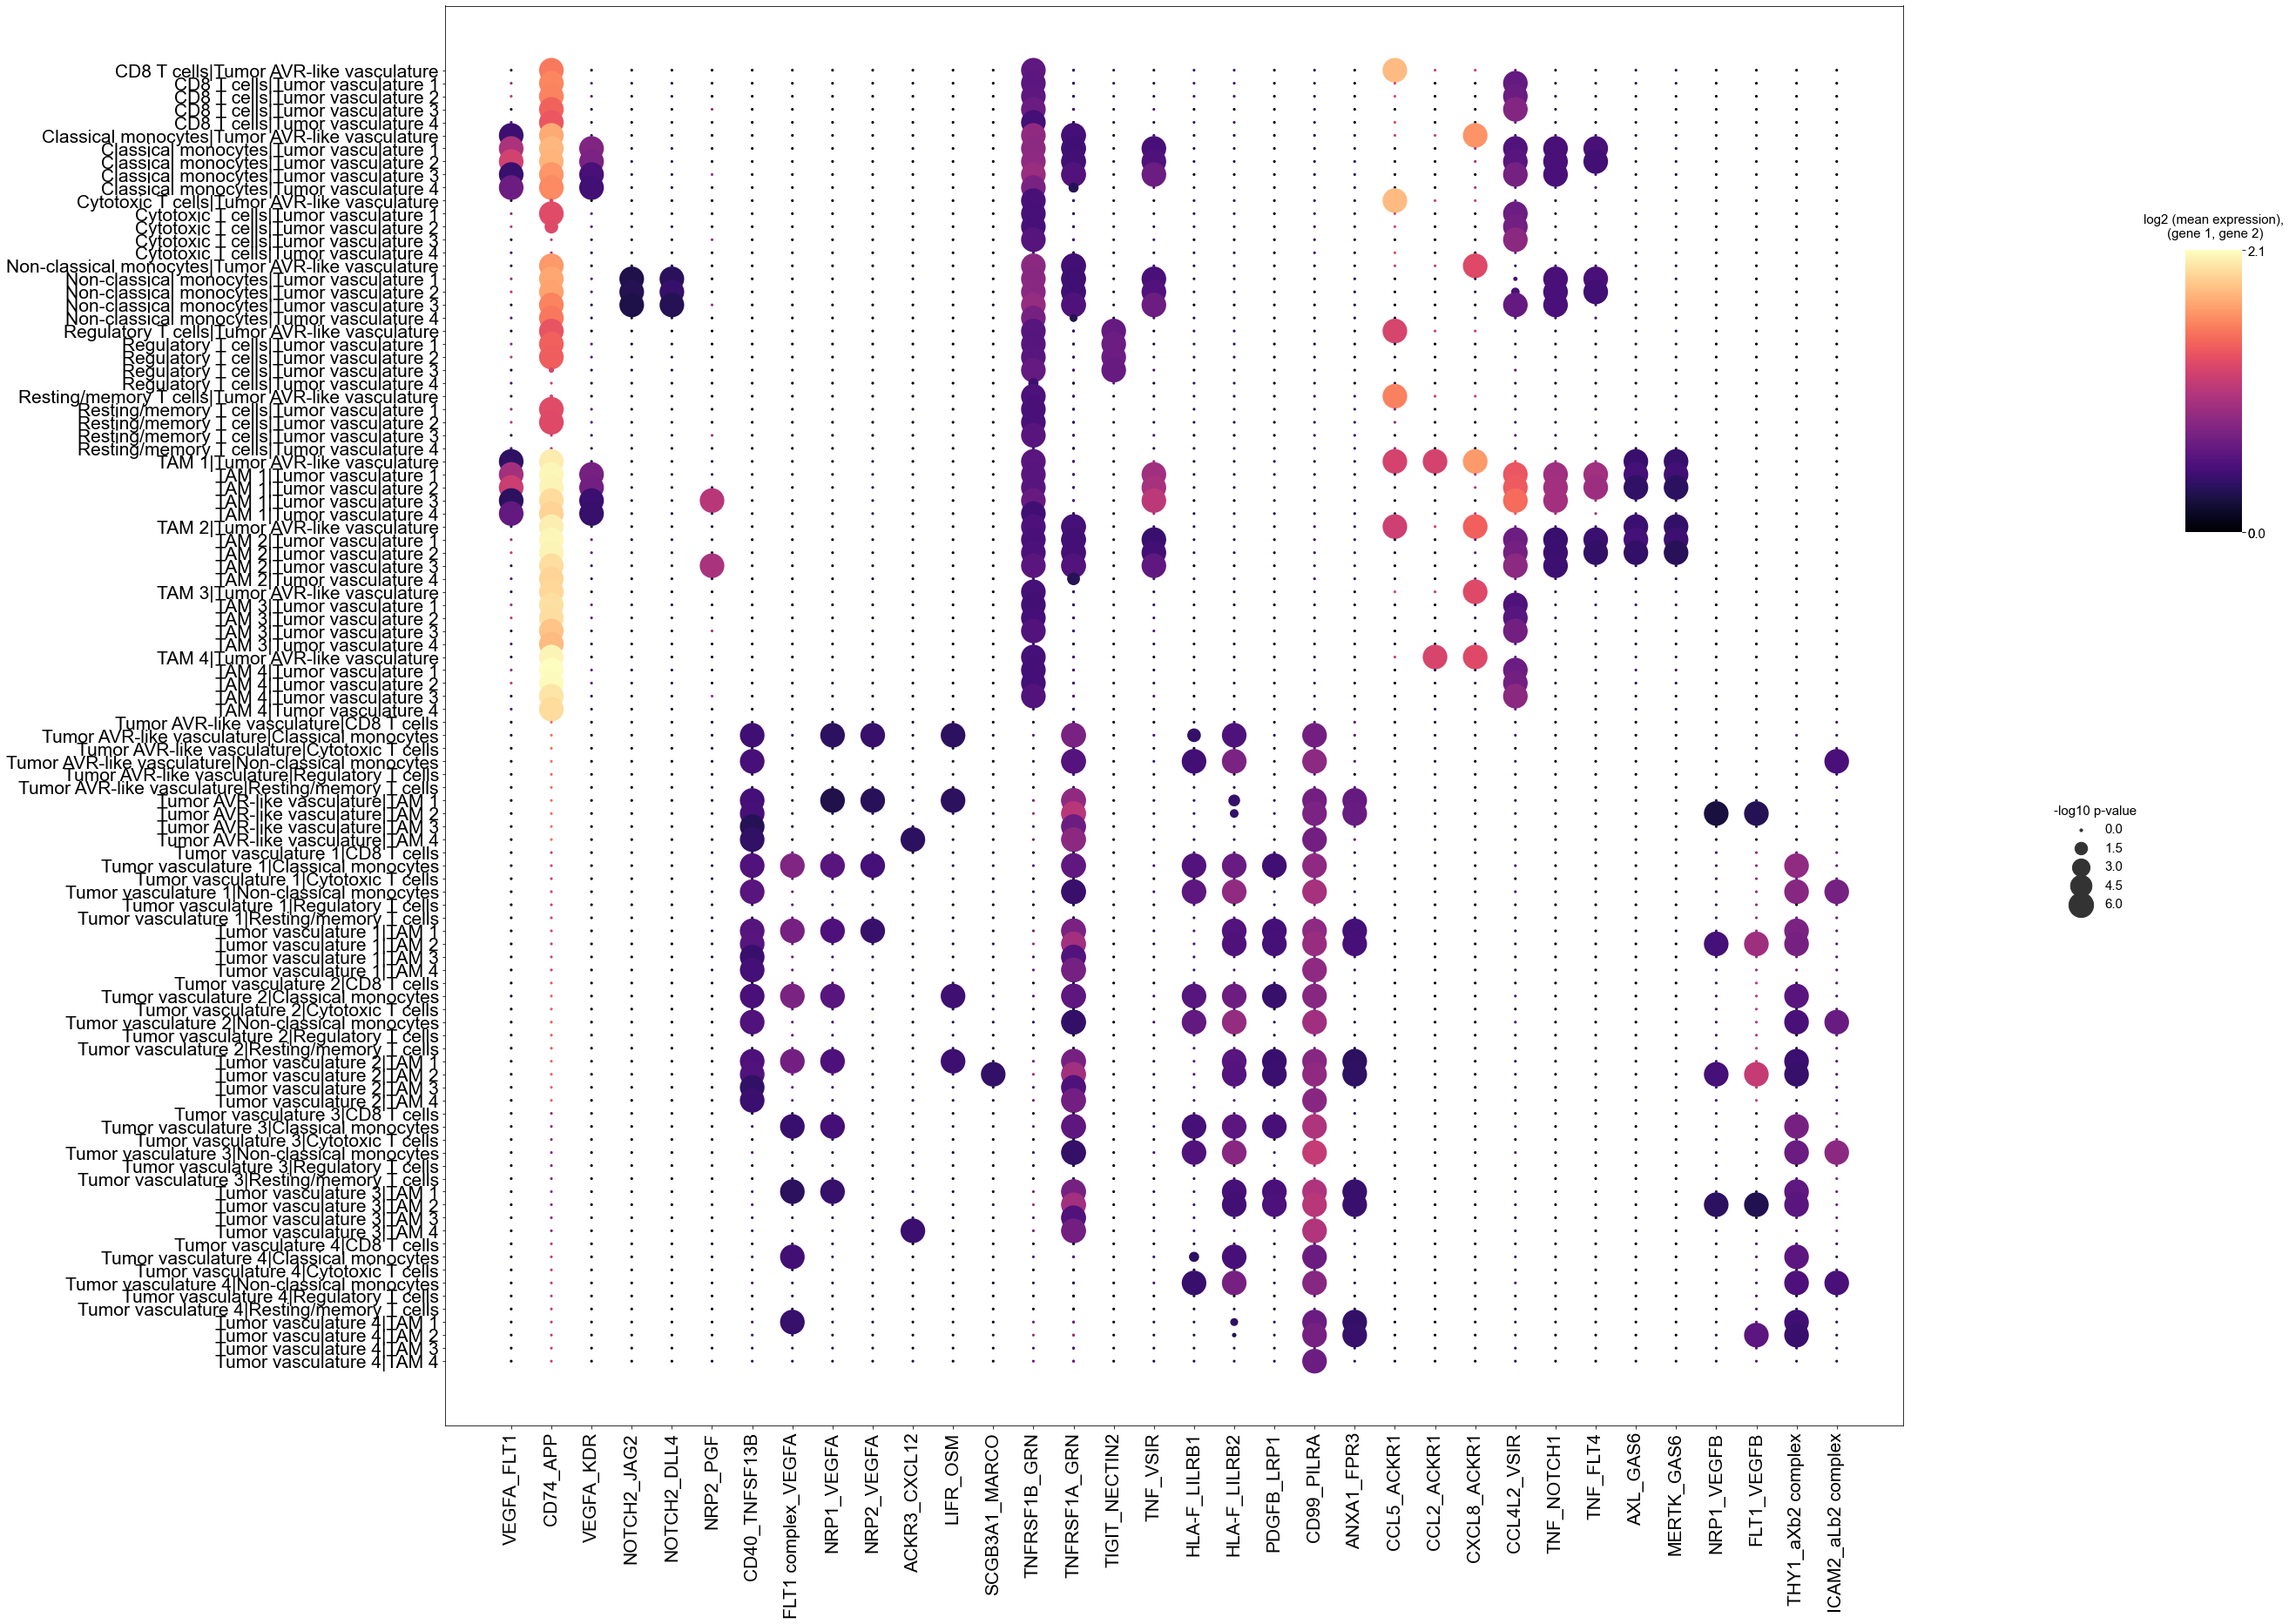

In [12]:
plot_cpdb_dotplot(int1, figsize=(30, 30))

In [14]:
#changing the order of interactions
int_pairs = [
    
#angiogenesis 
'VEGFA_FLT1',
 'VEGFA_KDR',
 'NOTCH2_DLL4',
 'NOTCH2_JAG2',
 'NRP2_PGF',
 #'CD74_APP',
 'FLT1 complex_VEGFA',
 'NRP1_VEGFA',
 'NRP2_VEGFA',
'ACKR3_CXCL12',
 'LIFR_OSM',
 'CD40_TNFSF13B',

#immune supression
 'ANXA1_FPR3',
 'CD99_PILRA',
 'PDGFB_LRP1',
 'HLA-F_LILRB1',
 'HLA-F_LILRB2',
 'SCGB3A1_MARCO',
 'TNFRSF1A_GRN',
 'TIGIT_NECTIN2',
 'TNFRSF1B_GRN',
 'TNF_VSIR',
    
#cytokine regulation

 'CCL2_ACKR1',
 'CCL4L2_VSIR',
 'CCL5_ACKR1',
 'CXCL8_ACKR1',
    
#proliferation and survival
 'FLT1_VEGFB',
 'NRP1_VEGFB',
 #'MERTK_GAS6',
 'AXL_GAS6',
 'TNF_FLT4',
 'TNF_NOTCH1',
    
#adhesion
 'ICAM2_aLb2 complex',
 'THY1_aXb2 complex'
 
]

In [15]:
endo_imm_int = int1.loc[int_pairs]

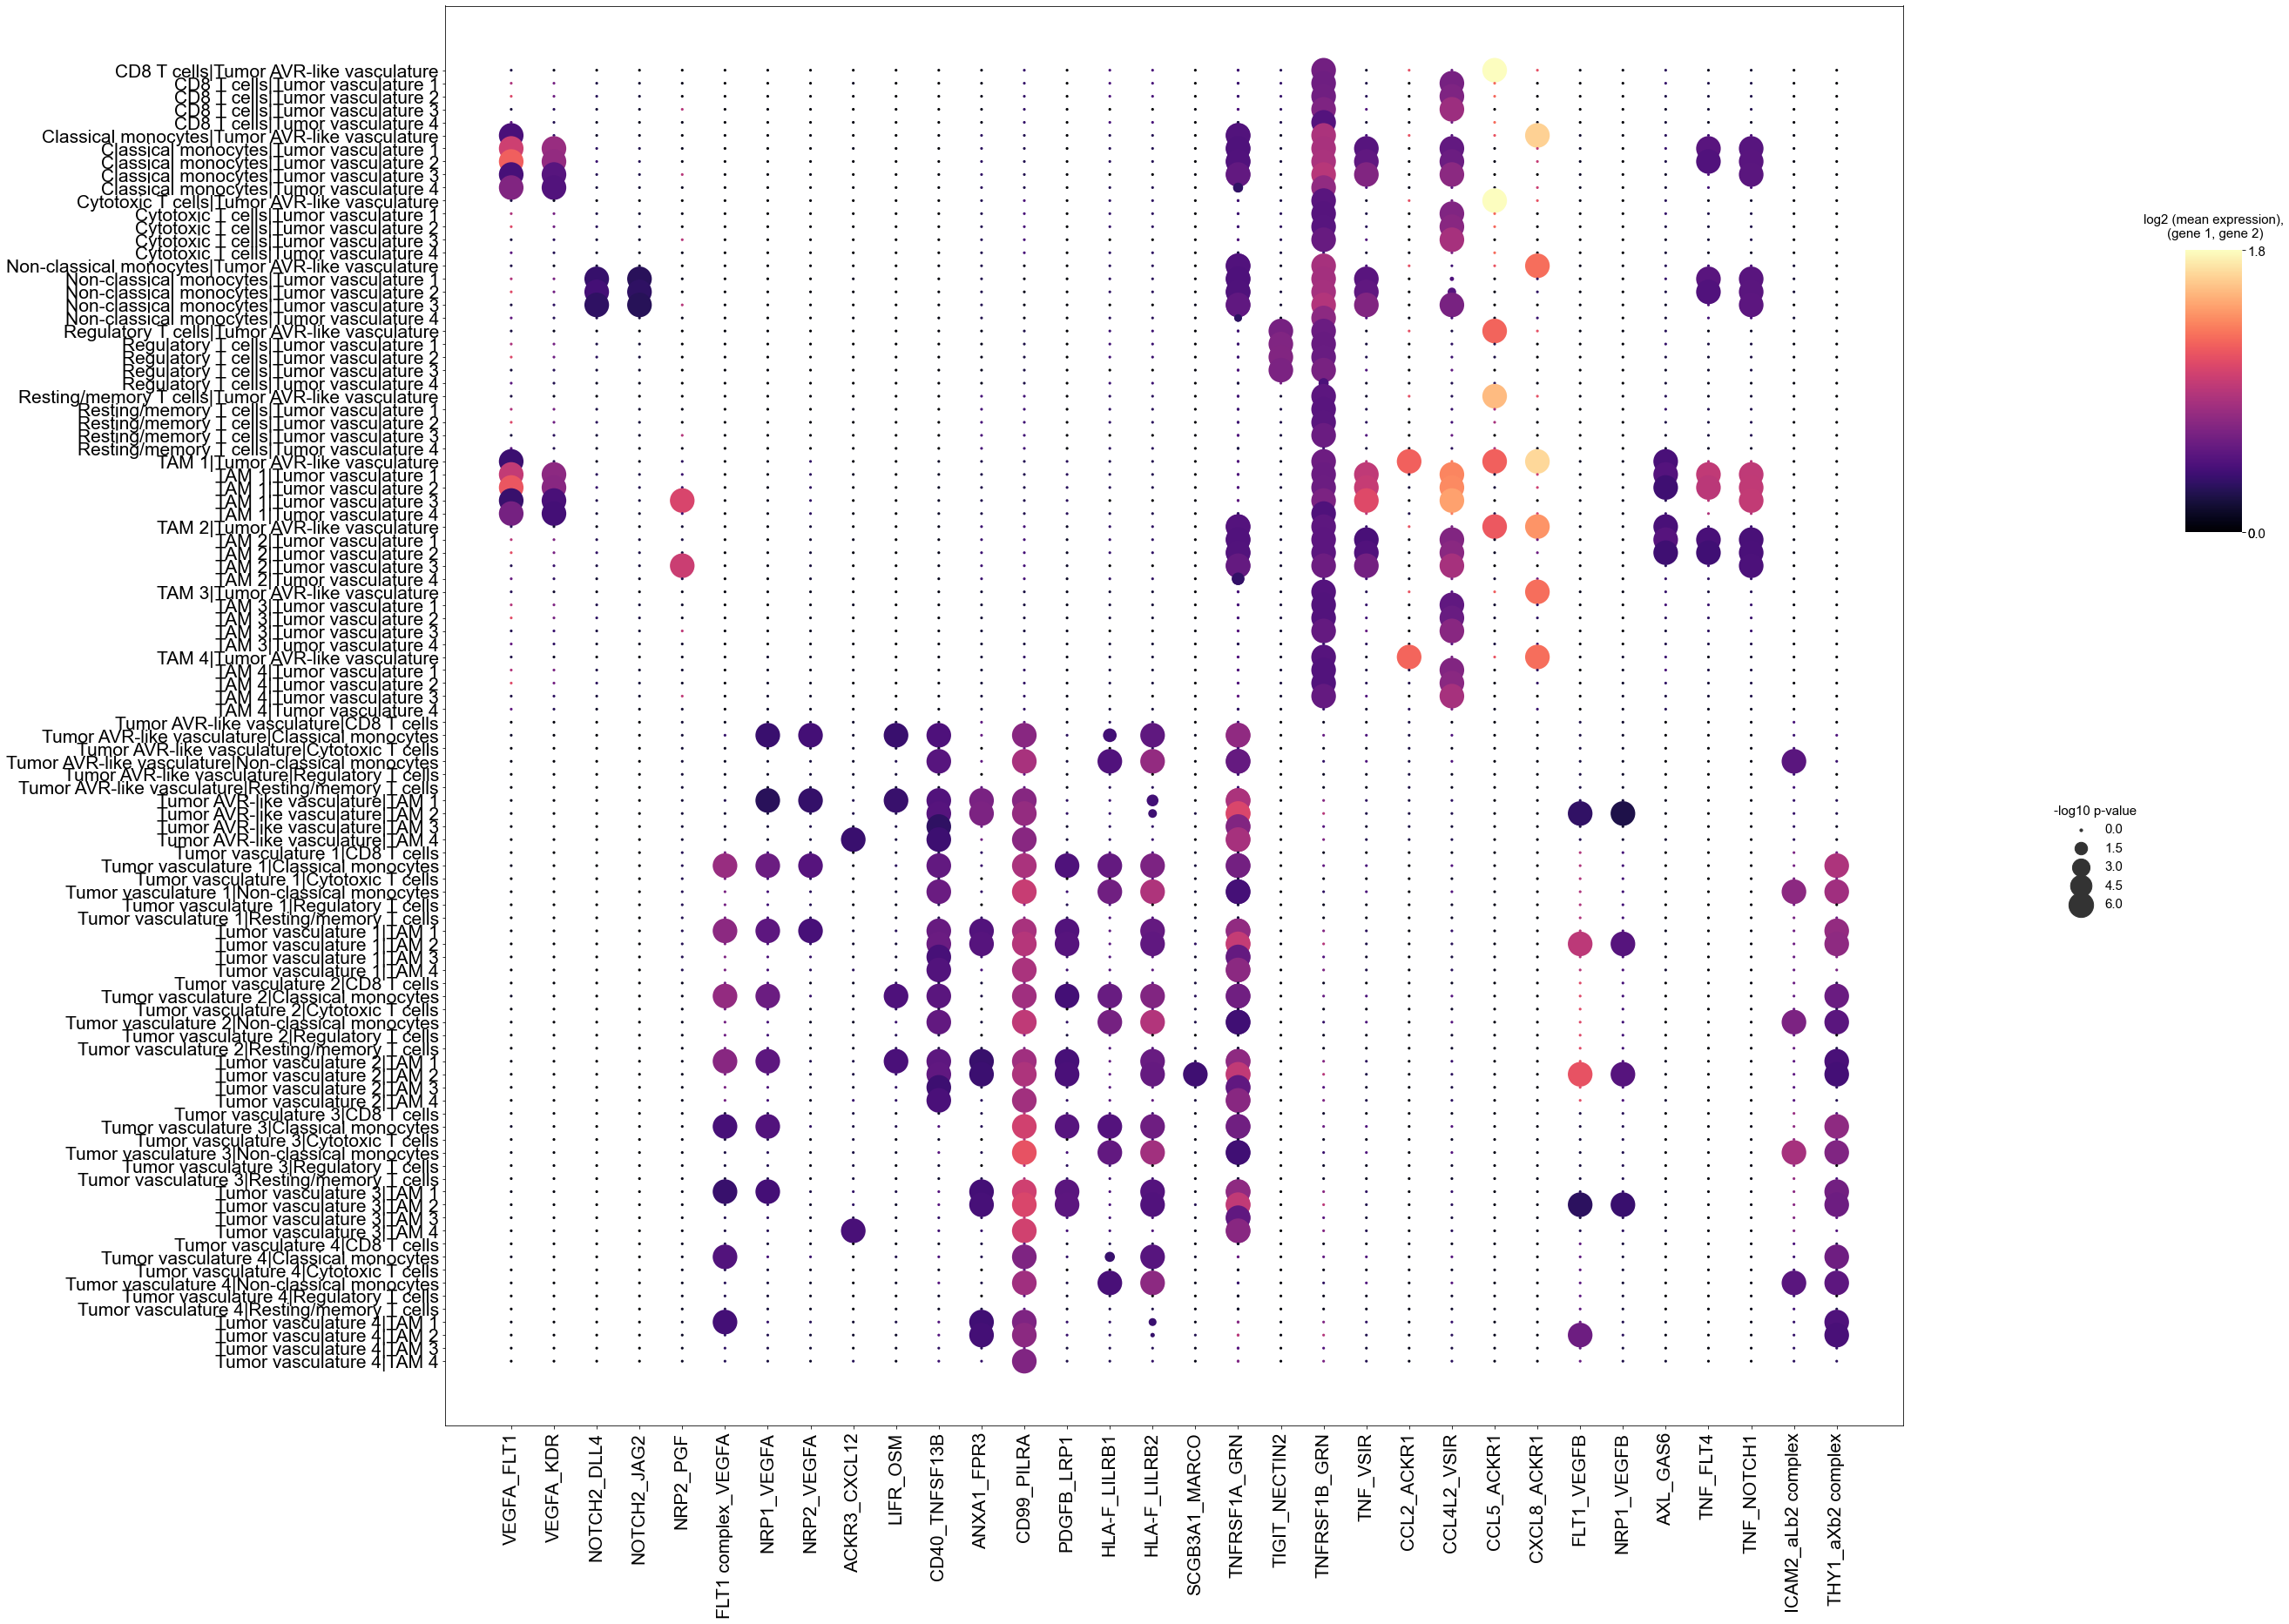

In [16]:
plot_cpdb_dotplot(endo_imm_int, figsize=(30, 30))

In [18]:
#removing some non-informative clutter from the dataset

mask = ~endo_imm_int['type_a'].isin(['Resting/memory T cells', 'CD8 T cells'])
mask2 = ~endo_imm_int['type_b'].isin(['Resting/memory T cells', 'CD8 T cells'])

final_mask=mask&mask2

In [19]:
endo_imm_filt=endo_imm_int[mask&mask2]

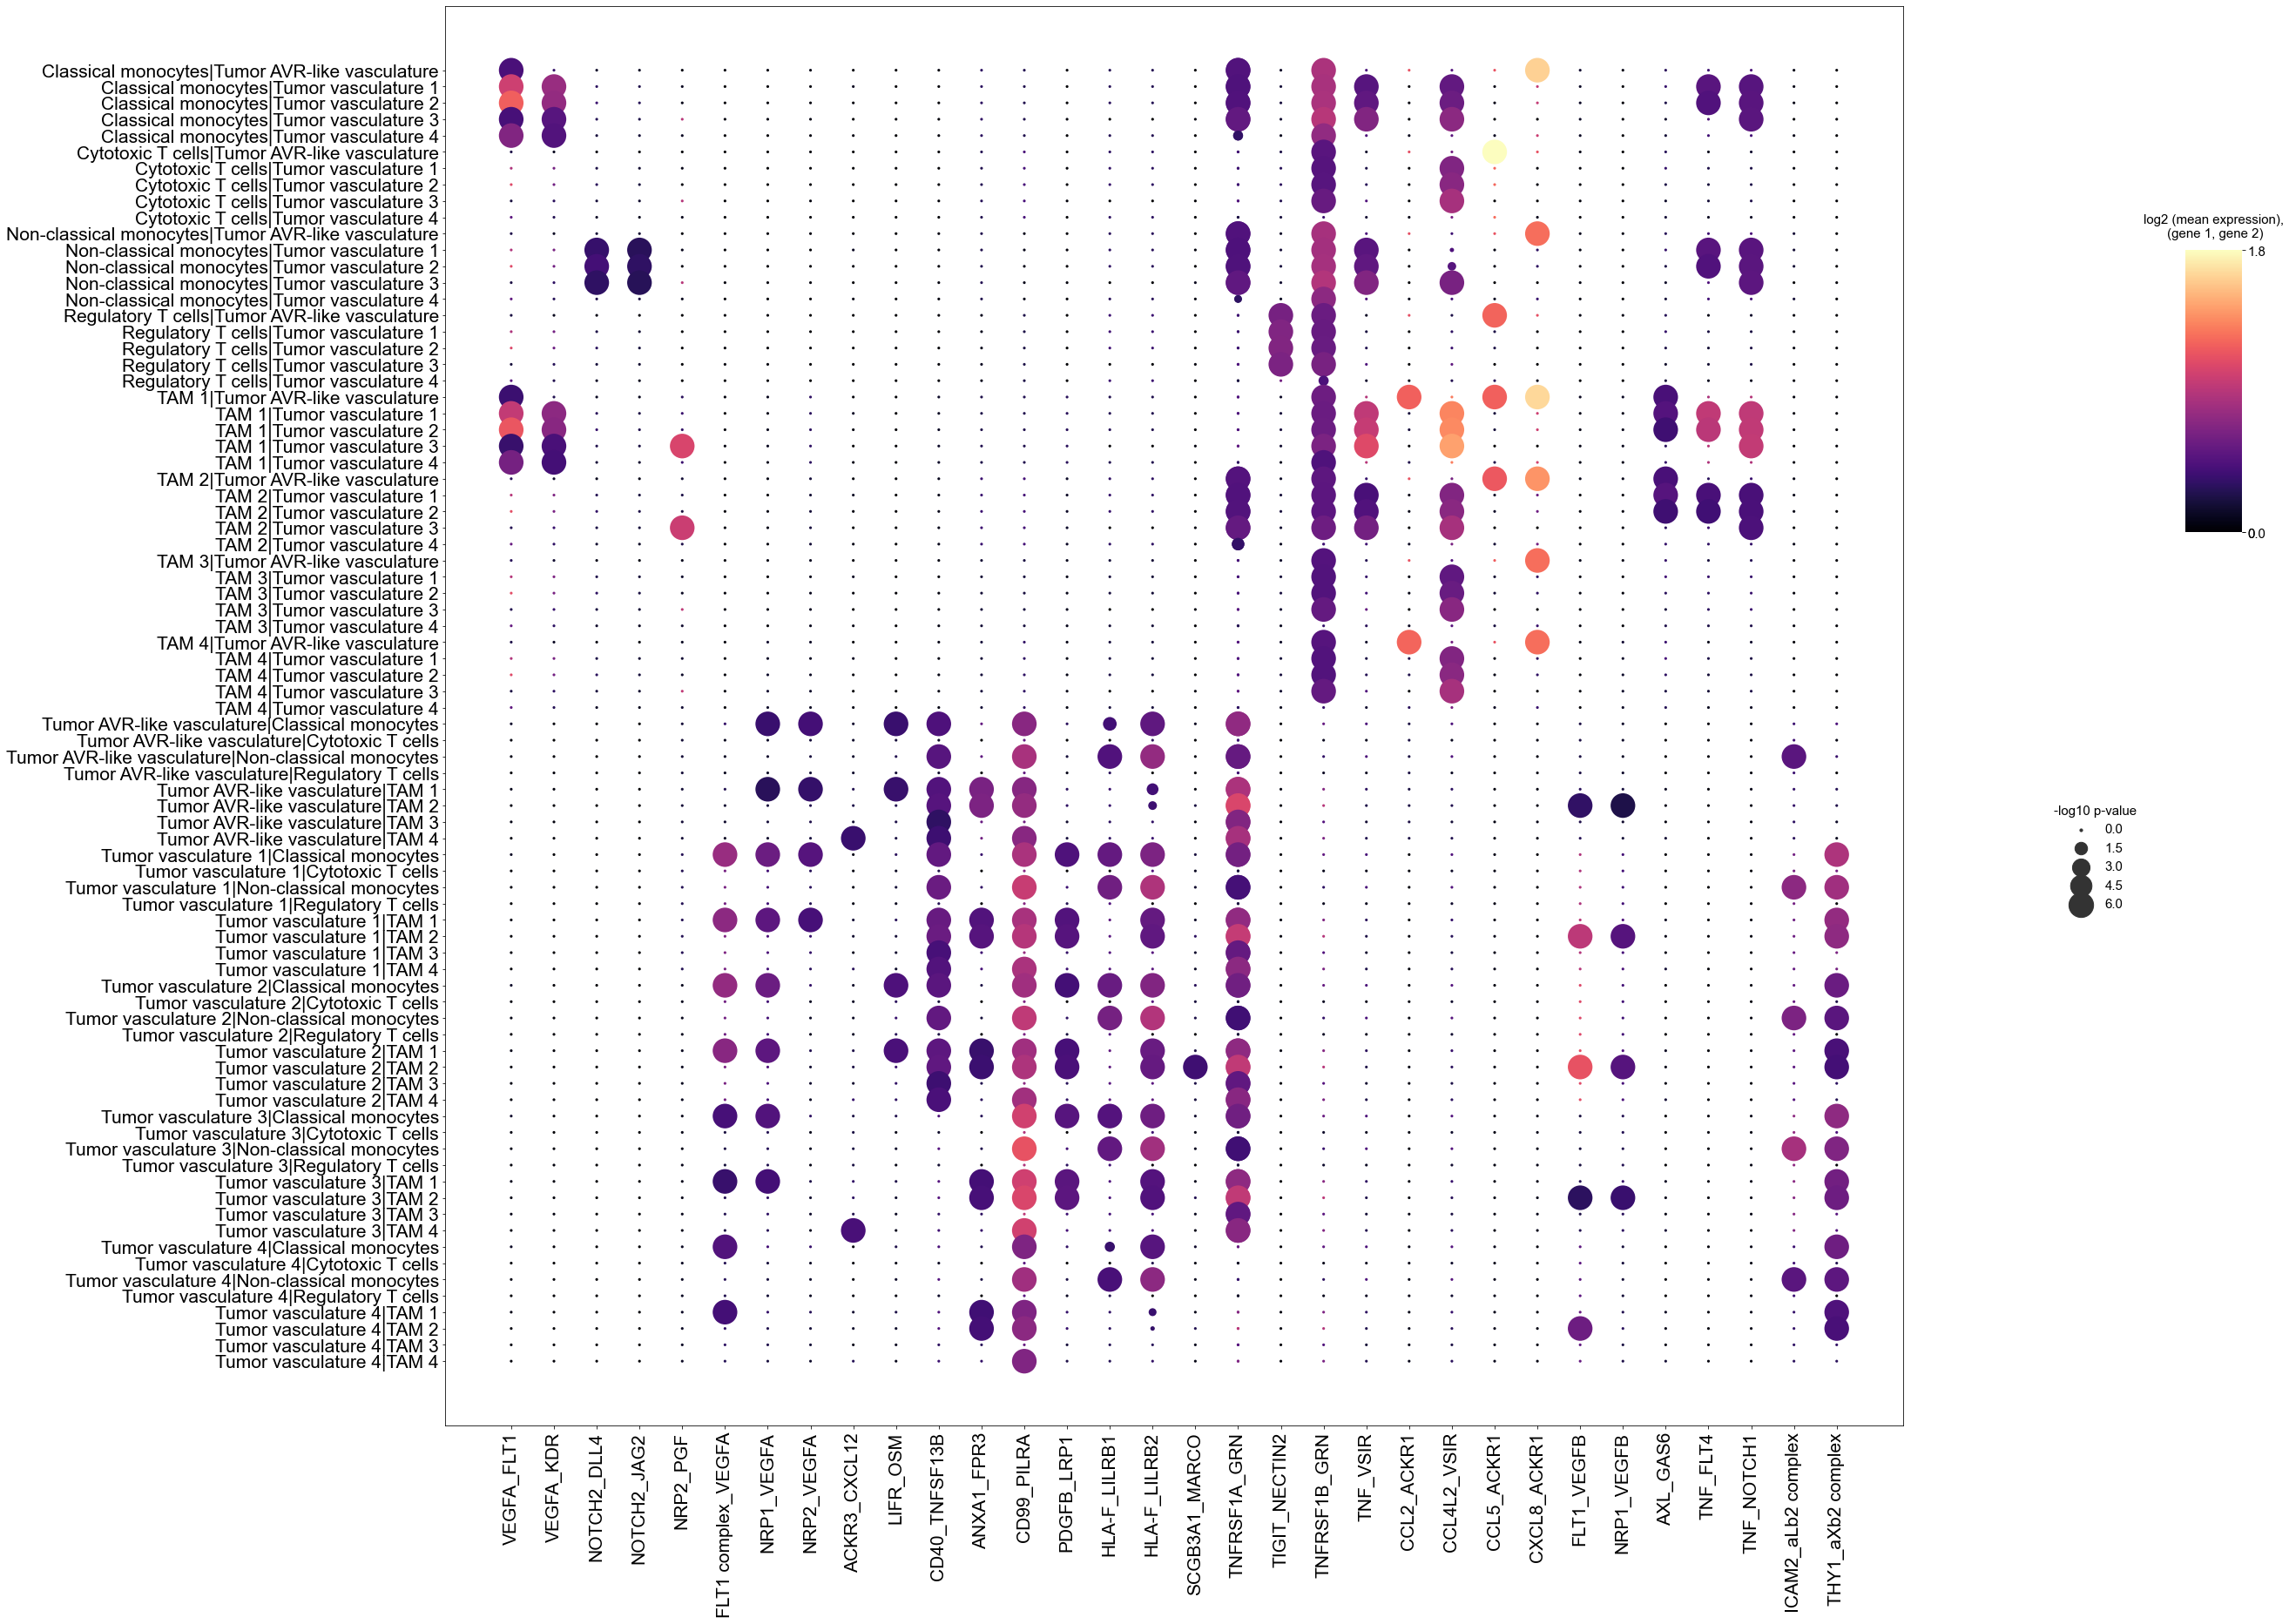

In [20]:
plot_cpdb_dotplot(endo_imm_filt, figsize=(30, 30))

In [21]:
#the plot is very big. let's separate the immune->endo and endo->immune parts. 
endo_imm_filt['type_a'].unique()

array(['Classical monocytes', 'Cytotoxic T cells',
       'Non-classical monocytes', 'Regulatory T cells', 'TAM 1', 'TAM 2',
       'TAM 3', 'TAM 4', 'Tumor AVR-like vasculature',
       'Tumor vasculature 1', 'Tumor vasculature 2',
       'Tumor vasculature 3', 'Tumor vasculature 4'], dtype=object)

In [22]:
mask3 = endo_imm_int['type_a'].isin(['Classical monocytes', 'Cytotoxic T cells',
       'Non-classical monocytes', 'Regulatory T cells', 'TAM 1', 'TAM 2',
       'TAM 3', 'TAM 4'])

In [23]:
imm_endo = endo_imm_int[mask3]


In [24]:
#removing the opposing direction interactions
int_pairs_imm = [
    
#angiogenesis 
'VEGFA_FLT1',
 'VEGFA_KDR',
 'NOTCH2_DLL4',
 'NOTCH2_JAG2',
 'NRP2_PGF',
 #'CD74_APP',
# 'FLT1 complex_VEGFA',
# 'NRP1_VEGFA',
# 'NRP2_VEGFA',
#'ACKR3_CXCL12',
# 'LIFR_OSM',
# 'CD40_TNFSF13B',

#immune supression
 #'ANXA1_FPR3',
 #'CD99_PILRA',
 #'PDGFB_LRP1',
 #'HLA-F_LILRB1',
 #'HLA-F_LILRB2',
 #'SCGB3A1_MARCO',
 'TNFRSF1A_GRN',
 'TIGIT_NECTIN2',
 'TNFRSF1B_GRN',
 'TNF_VSIR',
    
#cytokine regulation

 'CCL2_ACKR1',
 'CCL4L2_VSIR',
 'CCL5_ACKR1',
 'CXCL8_ACKR1',
    
#proliferation and survival
# 'FLT1_VEGFB',
# 'NRP1_VEGFB',
 #'MERTK_GAS6',
 'AXL_GAS6',
 'TNF_FLT4',
 'TNF_NOTCH1',
    
#adhesion
# 'ICAM2_aLb2 complex',
# 'THY1_aXb2 complex'
 
]

In [25]:
imm_endo =imm_endo.loc[int_pairs_imm]

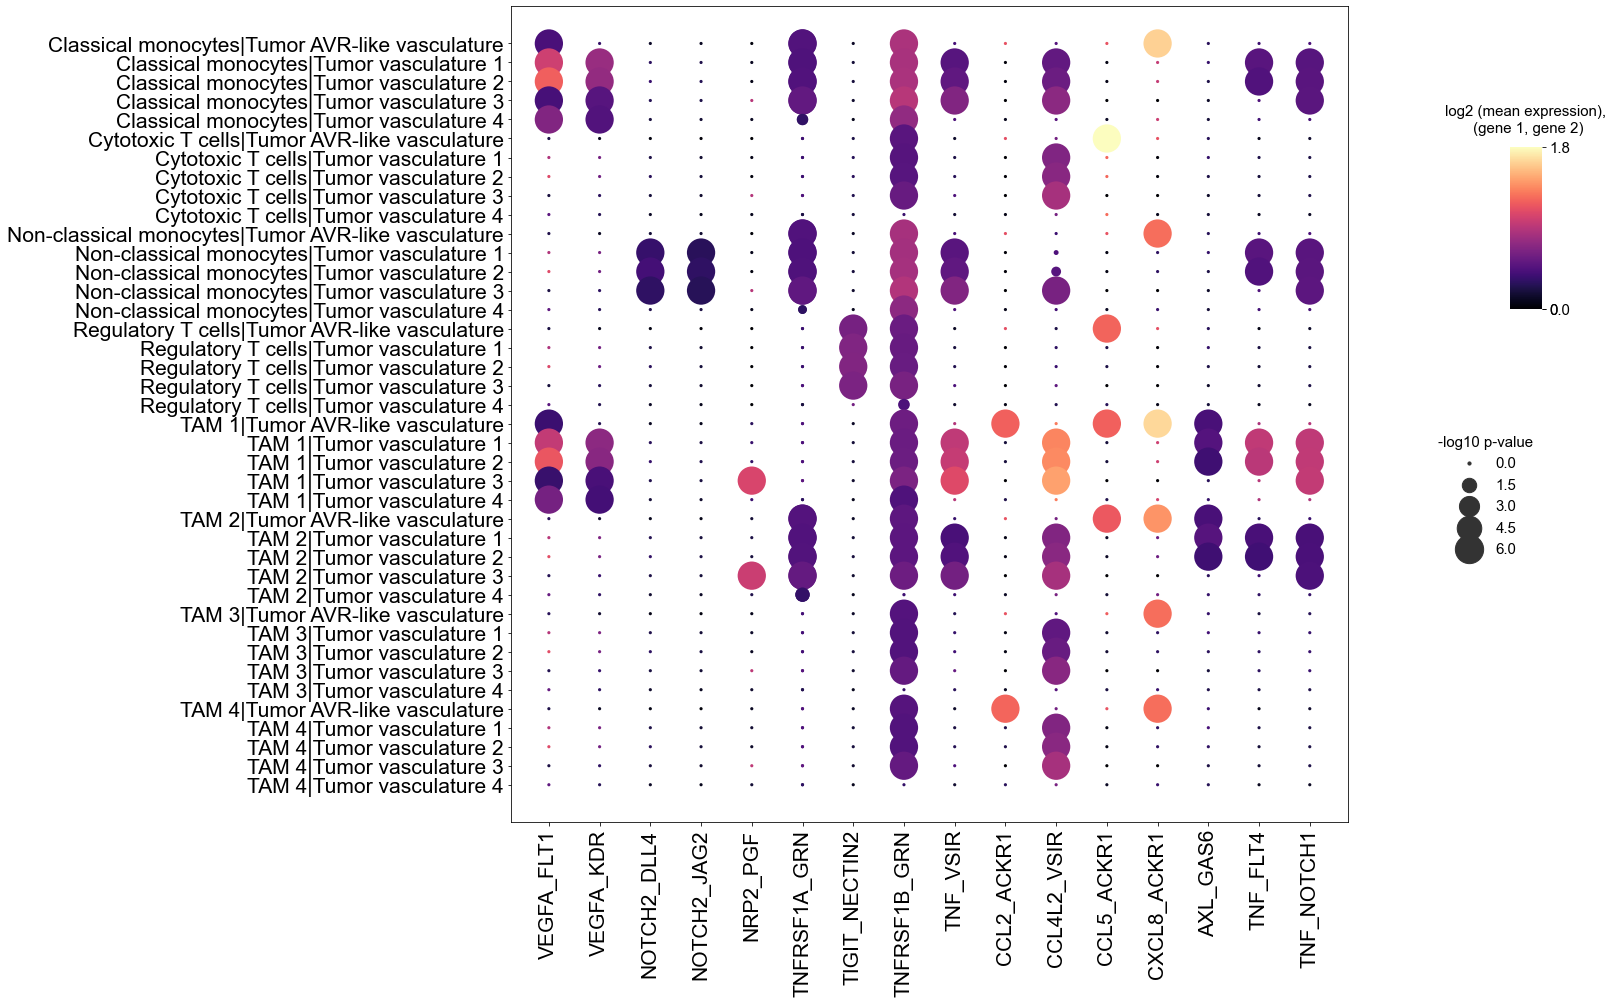

In [26]:
plot_cpdb_dotplot(imm_endo, figsize=(15, 15))

In [28]:
#removing some pairs that have no significant interactions
mask4=~imm_endo['pair'].isin(['Cytotoxic T cells|Tumor vasculature 4', 'TAM 3|Tumor vasculature 4','TAM 4|Tumor vasculature 4'])

imm_endo2=imm_endo[mask4]


### Add the shorter labels

In [30]:
new_labels=[]
for i in imm_endo2.pair:
    both = i.split('|')
    pair1 = both[0]
    pair2= both[1]
    if pair1 in renamer.keys():
        pair1=renamer[pair1]
    if pair2 in renamer.keys():
        pair2=renamer[pair2]
    new_label=pair1 + '|' + pair2
    new_labels.append(new_label)
imm_endo2['pair2'] = new_labels
    

<ipython-input-30-4c1d3574897c>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imm_endo2['pair2'] = new_labels


In [33]:
##make it nice!


def plot_cpdb_dotplot_fancy(data, figsize =(20, 4)):
    cmap =sns.color_palette("magma", as_cmap=True)
    mpl.rcParams['axes.grid'] = False
    mpl.rcParams['legend.frameon'] = False
    fig, ax = plt.subplots(figsize=figsize)
    ax1 = sns.scatterplot(x=data.index, y=data['pair2'], 
                size=data['-log10 p-value'],  sizes = (10, 650),
                hue=np.log2(data["mean"]), data=data, palette='magma',  linewidth=0)
    
    ax1.set_facecolor('white')
    ax1.set_frame_on(False)
    #removing the 'pair' labels
    ax1.set(ylabel=None)
    ax1.set(xlabel=None)
    plt.draw()
    #ax1.set_xticks()
    
    
    labelsx = ax1.xaxis.get_ticklabels(which='both')
    labels_redx = [str(i.get_text()).split('_')[0] for i in labelsx]
    labels_blackx = [str(i.get_text()).split('_')[1] for i in labelsx]
    
    labelsy = ax1.yaxis.get_ticklabels(which='both')
    labels_redy = [str(i.get_text()).split('|')[0] for i in labelsy]
    labels_blacky = [str(i.get_text()).split('|')[1] for i in labelsy]
    
    ax1.set_xticklabels([])
    ax1.set_yticklabels(labels_blacky, fontsize=21)
    
    for i in range(len(labels_redx)):
        boxes = [TextArea(text, textprops=dict(color=color, rotation=90, horizontalalignment='right', fontsize=21))
                   for text, color in zip([labels_redx[i], '--', labels_blackx[i]][::-1], ['black', 'grey', 'purple'])]
        xbox = VPacker(children=boxes, align="right", pad=0, sep=0)
        anchored_xbox = AnchoredOffsetbox(loc='upper right', child=xbox, pad=0, frameon=False, bbox_to_anchor=(i+0.9, len(labels_blacky)),
                                       bbox_transform=ax1.transData, borderpad=0)
        ax1.add_artist(anchored_xbox)
    
    #using part of legend for accurate legend dot sizes
    h,l = ax1.get_legend_handles_labels()
    index_of_label = []
    for i, label in enumerate(l):
        if label=='-log10 p-value':
            index_of_label.append(i)
            new_label = round(float(l[i+1]), 2)
            l[i+1] = new_label
           
            
    ax1.legend(h[index_of_label[0]+1:], l[index_of_label[0]+1:], 
               bbox_to_anchor=(1.14,0.4), loc="center left", borderaxespad=0, 
               fontsize=15,
              title = '-log10 p-value', title_fontsize=15, labelspacing =0.7, 
              markerscale=0.9)
    
    #get max and min values for colorbar
    vmax = round(np.percentile(max(np.log2(data["mean"])), 99), 1)
    vmin = round(min(np.log2(data['mean'])), 1)
    norm = mpl.colors.Normalize(0, vmax)
   
   # # colorbar
    caxb = fig.add_axes([1.05, 0.6, 0.03, 0.15])
    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=caxb, orientation='vertical')
    cbar.outline.set_visible(False)
    c = [vmin, 0,  vmax]
    cbar.set_ticks(c)
    cbar.ax.set_yticklabels(c, fontsize = 15)
    cbar.ax.set_title('log2 (mean expression),\n (gene 1, gene 2)', fontsize=15, pad = 15)
    
 
    #Add the lines for interacting cell types
    x,y = np.array([[-10, -10, -10], [-0.2, 4.2, 0]])
    line1 = Line2D(x, y, lw=2., color='grey')
    x1,y1 = np.array([[-10, -10, -10], [4.6, 8, 8.2]])
    line2 = Line2D(x1, y1, lw=2., color='grey')
    x2,y2 = np.array([[-10, -10, -10], [8.6, 13, 13.2]])
    line3 = Line2D(x2, y2, lw=2., color='grey')
    x3,y3 = np.array([[-10, -10, -10], [13.6, 18, 18.2]])
    line4 = Line2D(x3, y3, lw=2., color='grey')
    x4,y4 = np.array([[-10, -10, -10], [18.6, 23, 23.2]])
    line5 = Line2D(x4, y4, lw=2., color='grey')
    x5,y5 = np.array([[-10, -10, -10], [23.6, 28, 28.2]])
    line6 = Line2D(x5, y5, lw=2., color='grey')
    x6,y6 = np.array([[-10, -10, -10], [28.6, 32, 32.2]])
    line7 = Line2D(x6, y6, lw=2., color='grey')
    x7,y7 = np.array([[-10, -10, -10], [32.6, 36.2, 36.4]])
    line8 = Line2D(x7, y7, lw=2., color='grey')
    line1.set_clip_on(False)
    line2.set_clip_on(False)
    line3.set_clip_on(False)
    line4.set_clip_on(False)
    line5.set_clip_on(False)
    line6.set_clip_on(False)
    line7.set_clip_on(False)
    line8.set_clip_on(False)
    ax1.add_line(line1)
    ax1.add_line(line2)
    ax1.add_line(line3)
    ax1.add_line(line4)
    ax1.add_line(line5)
    ax1.add_line(line6)
    ax1.add_line(line7)
    ax1.add_line(line8)
    ax1.text(-16.8, 2.0, 'CD14+ Mono', color = 'purple', fontsize=21)
    ax1.text(-15.5, 6.5, 'Cytotoxic T cells', color = 'purple', fontsize=21)
    ax1.text(-14.8, 11.5, 'CD16+ Mono', color = 'purple', fontsize=21)
    ax1.text(-16.2, 16, 'T reg', color = 'purple', fontsize=21)
    ax1.text(-12.5, 21, 'TAM 1', color = 'purple', fontsize=21)
    ax1.text(-12.5, 26, 'TAM 2', color = 'purple', fontsize=21)
    ax1.text(-12.5, 30.5, 'TAM 3', color = 'purple', fontsize=21)
    ax1.text(-12.5, 34.8, 'TAM 4', color = 'purple', fontsize=21)
    plt.setp(ax.get_xticklabels(), rotation=90)
    
    

    plt.savefig('figures_paper/immune_endo_int.pdf', dpi=600, bbox_inches='tight')
    plt.show()

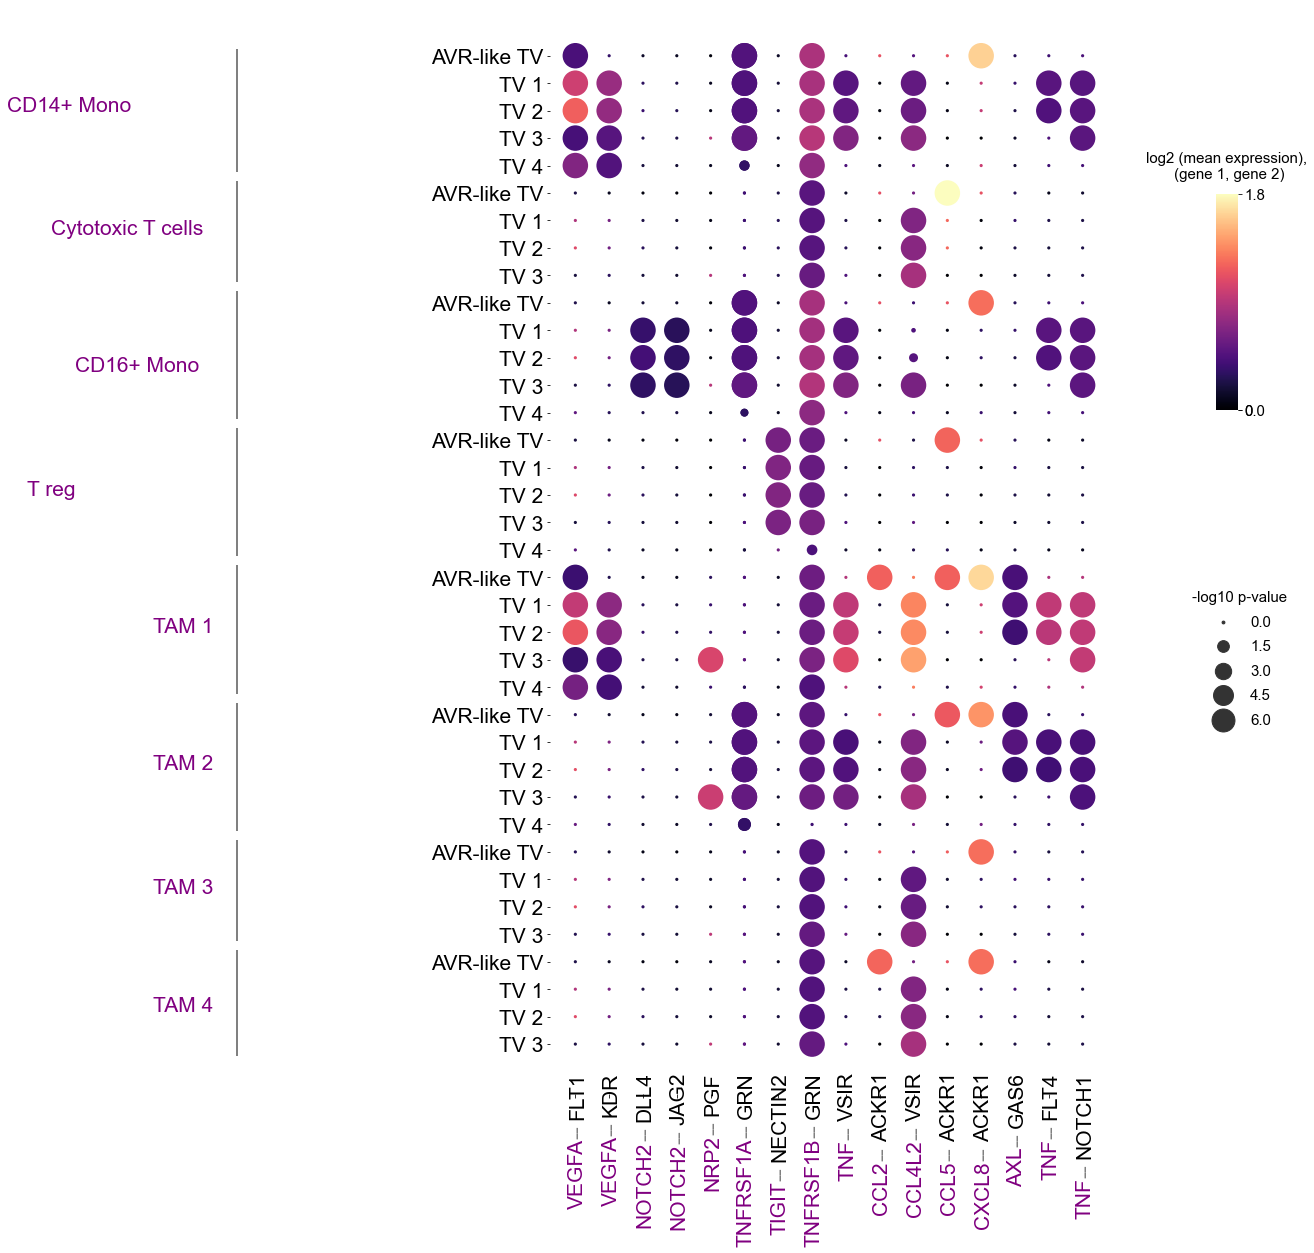

In [34]:
plot_cpdb_dotplot_fancy(imm_endo2, figsize=(10, 20))

In [35]:
## Note:  further cosmetic changes are made using Illustrator

## Endo - immune

In [36]:
mask4 = endo_imm_int['type_a'].isin(['Tumor AVR-like vasculature',
       'Tumor vasculature 1', 'Tumor vasculature 2',
       'Tumor vasculature 3', 'Tumor vasculature 4'])

In [37]:
endo_imm = endo_imm_int[mask4]

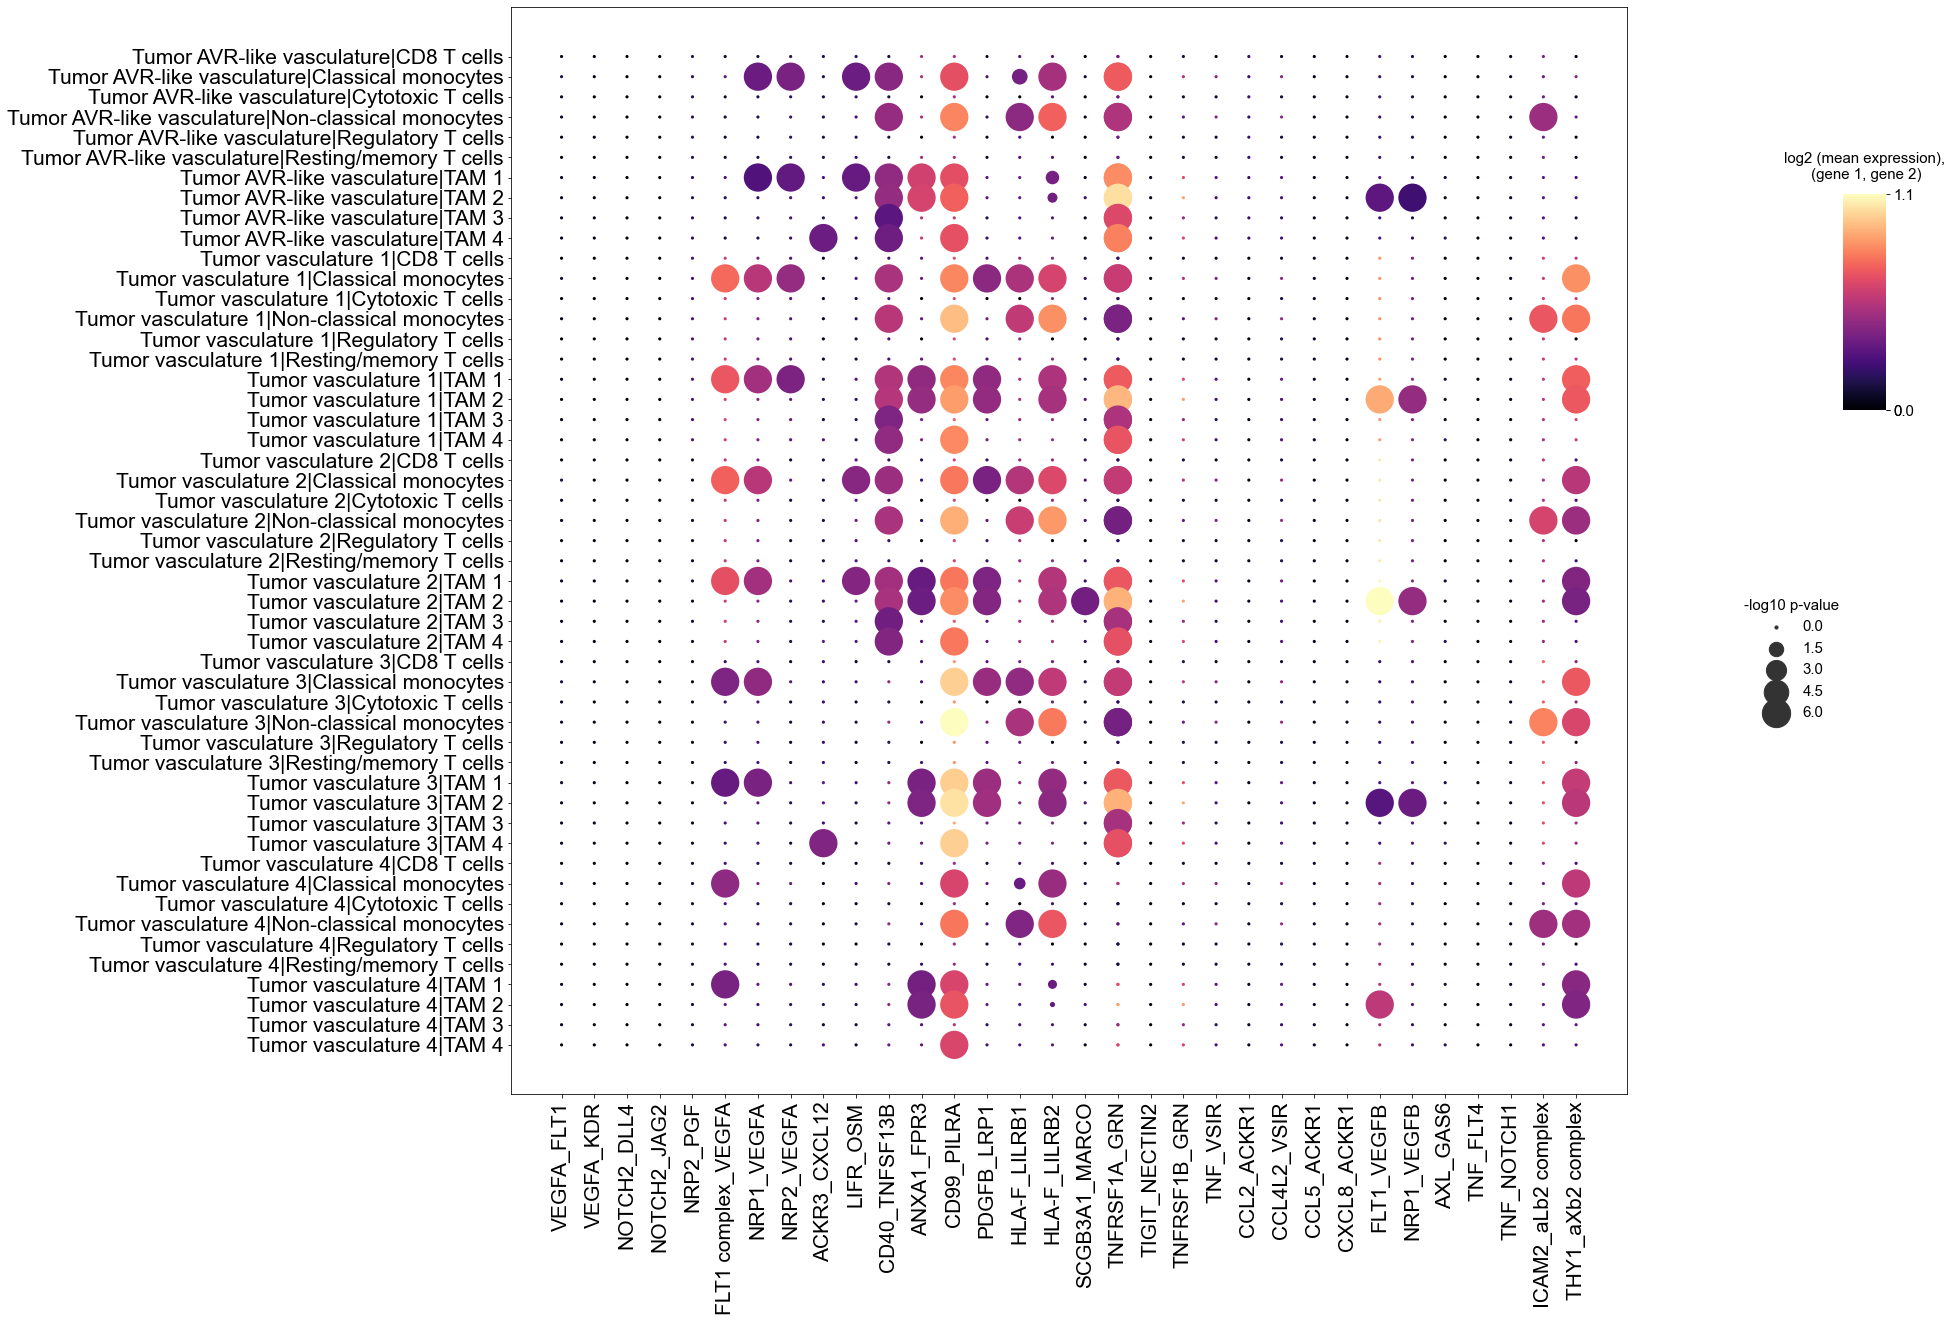

In [38]:
plot_cpdb_dotplot(endo_imm, figsize=(20, 20))

In [39]:
#removing the opposing direction interactions
int_pairs_endo = [
    
#angiogenesis 
#'VEGFA_FLT1',
 #'VEGFA_KDR',
 #'NOTCH2_DLL4',
 #'NOTCH2_JAG2',
 #'NRP2_PGF',
 #'CD74_APP',
 'FLT1 complex_VEGFA',
 'NRP1_VEGFA',
 'NRP2_VEGFA',
'ACKR3_CXCL12',
 'LIFR_OSM',
 'CD40_TNFSF13B',

#immune supression
 'ANXA1_FPR3',
 'CD99_PILRA',
 'PDGFB_LRP1',
 'HLA-F_LILRB1',
 'HLA-F_LILRB2',
 'SCGB3A1_MARCO',
 #'TNFRSF1A_GRN',
 #'TIGIT_NECTIN2',
 #'TNFRSF1B_GRN',
 #'TNF_VSIR',
    
#cytokine regulation

 #'CCL2_ACKR1',
 #'CCL4L2_VSIR',
 #'CCL5_ACKR1',
 #'CXCL8_ACKR1',
    
#proliferation and survival
 'FLT1_VEGFB',
 'NRP1_VEGFB',
 #'MERTK_GAS6',
 #'AXL_GAS6',
 #'TNF_FLT4',
 #'TNF_NOTCH1',
    
#adhesion
 'ICAM2_aLb2 complex',
 'THY1_aXb2 complex'
 
]

In [40]:
endo_imm_filt =endo_imm.loc[int_pairs_endo]

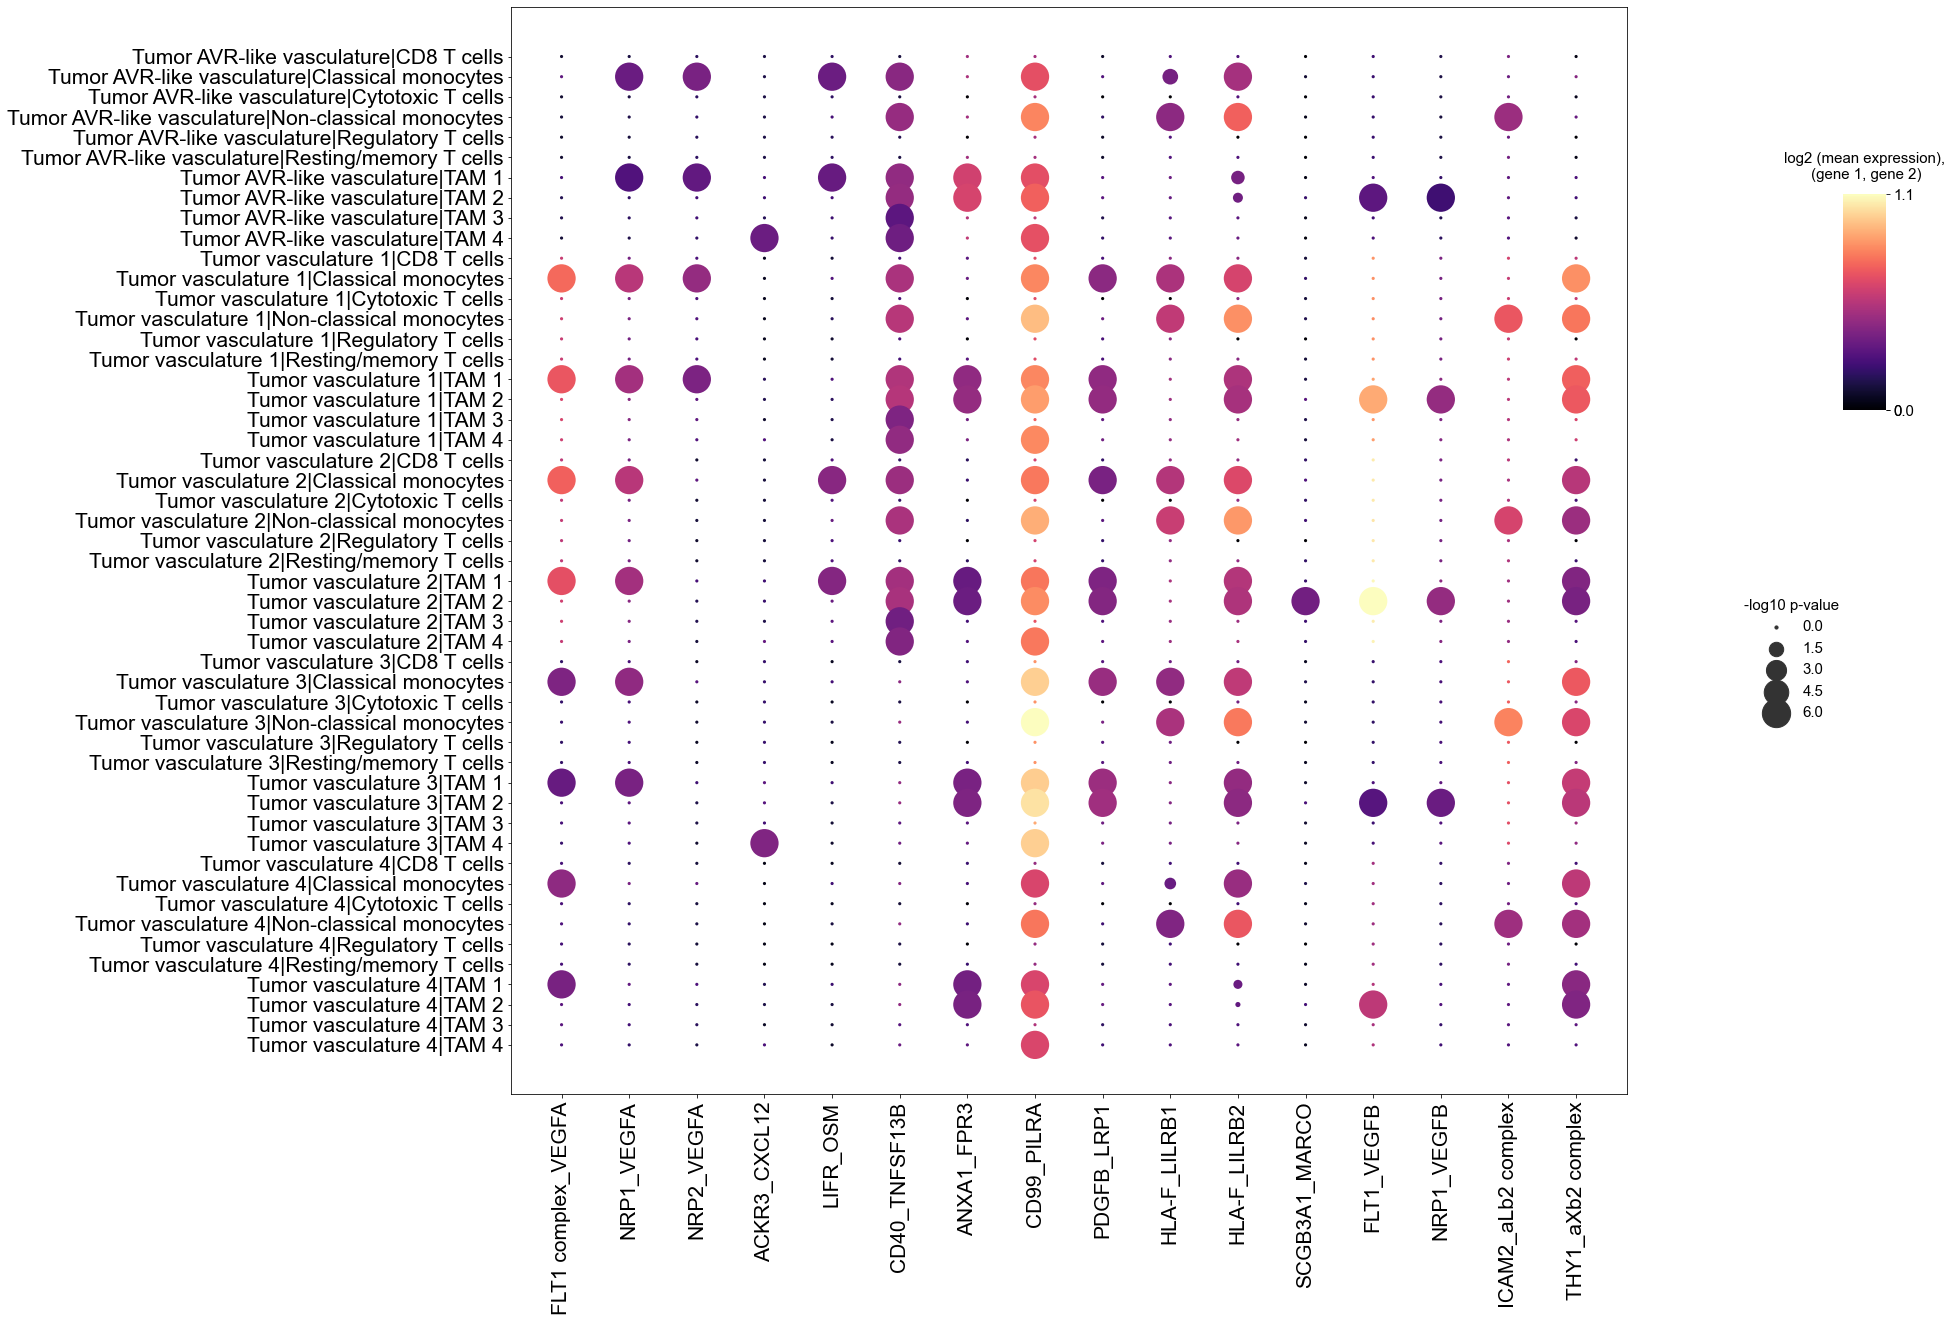

In [41]:
plot_cpdb_dotplot(endo_imm_filt, figsize=(20, 20))

In [42]:
endo_imm_filt['pair'].unique()

array(['Tumor AVR-like vasculature|CD8 T cells',
       'Tumor AVR-like vasculature|Classical monocytes',
       'Tumor AVR-like vasculature|Cytotoxic T cells',
       'Tumor AVR-like vasculature|Non-classical monocytes',
       'Tumor AVR-like vasculature|Regulatory T cells',
       'Tumor AVR-like vasculature|Resting/memory T cells',
       'Tumor AVR-like vasculature|TAM 1',
       'Tumor AVR-like vasculature|TAM 2',
       'Tumor AVR-like vasculature|TAM 3',
       'Tumor AVR-like vasculature|TAM 4',
       'Tumor vasculature 1|CD8 T cells',
       'Tumor vasculature 1|Classical monocytes',
       'Tumor vasculature 1|Cytotoxic T cells',
       'Tumor vasculature 1|Non-classical monocytes',
       'Tumor vasculature 1|Regulatory T cells',
       'Tumor vasculature 1|Resting/memory T cells',
       'Tumor vasculature 1|TAM 1', 'Tumor vasculature 1|TAM 2',
       'Tumor vasculature 1|TAM 3', 'Tumor vasculature 1|TAM 4',
       'Tumor vasculature 2|CD8 T cells',
       'Tumor vasculat

In [43]:
#removing some pairs that have no significant interactions
mask6=~endo_imm_filt['pair'].isin(['Tumor AVR-like vasculature|CD8 T cells',
                                  'Tumor AVR-like vasculature|Regulatory T cells',
       'Tumor AVR-like vasculature|Resting/memory T cells',  'Tumor AVR-like vasculature|Cytotoxic T cells',
                                   'Tumor vasculature 1|CD8 T cells', 'Tumor vasculature 1|Cytotoxic T cells',
                                  'Tumor vasculature 1|Regulatory T cells',
       'Tumor vasculature 1|Resting/memory T cells','Tumor vasculature 2|CD8 T cells',
                                  'Tumor vasculature 2|Regulatory T cells', 'Tumor vasculature 2|Cytotoxic T cells',
       'Tumor vasculature 2|Resting/memory T cells','Tumor vasculature 3|CD8 T cells',
                                  'Tumor vasculature 3|Regulatory T cells', 'Tumor vasculature 3|Cytotoxic T cells',
       'Tumor vasculature 3|Resting/memory T cells','Tumor vasculature 4|CD8 T cells',
                                  'Tumor vasculature 4|Regulatory T cells', 'Tumor vasculature 4|Cytotoxic T cells',
       'Tumor vasculature 4|Resting/memory T cells', 
                                  ])

endo_imm2=endo_imm_filt[mask6]

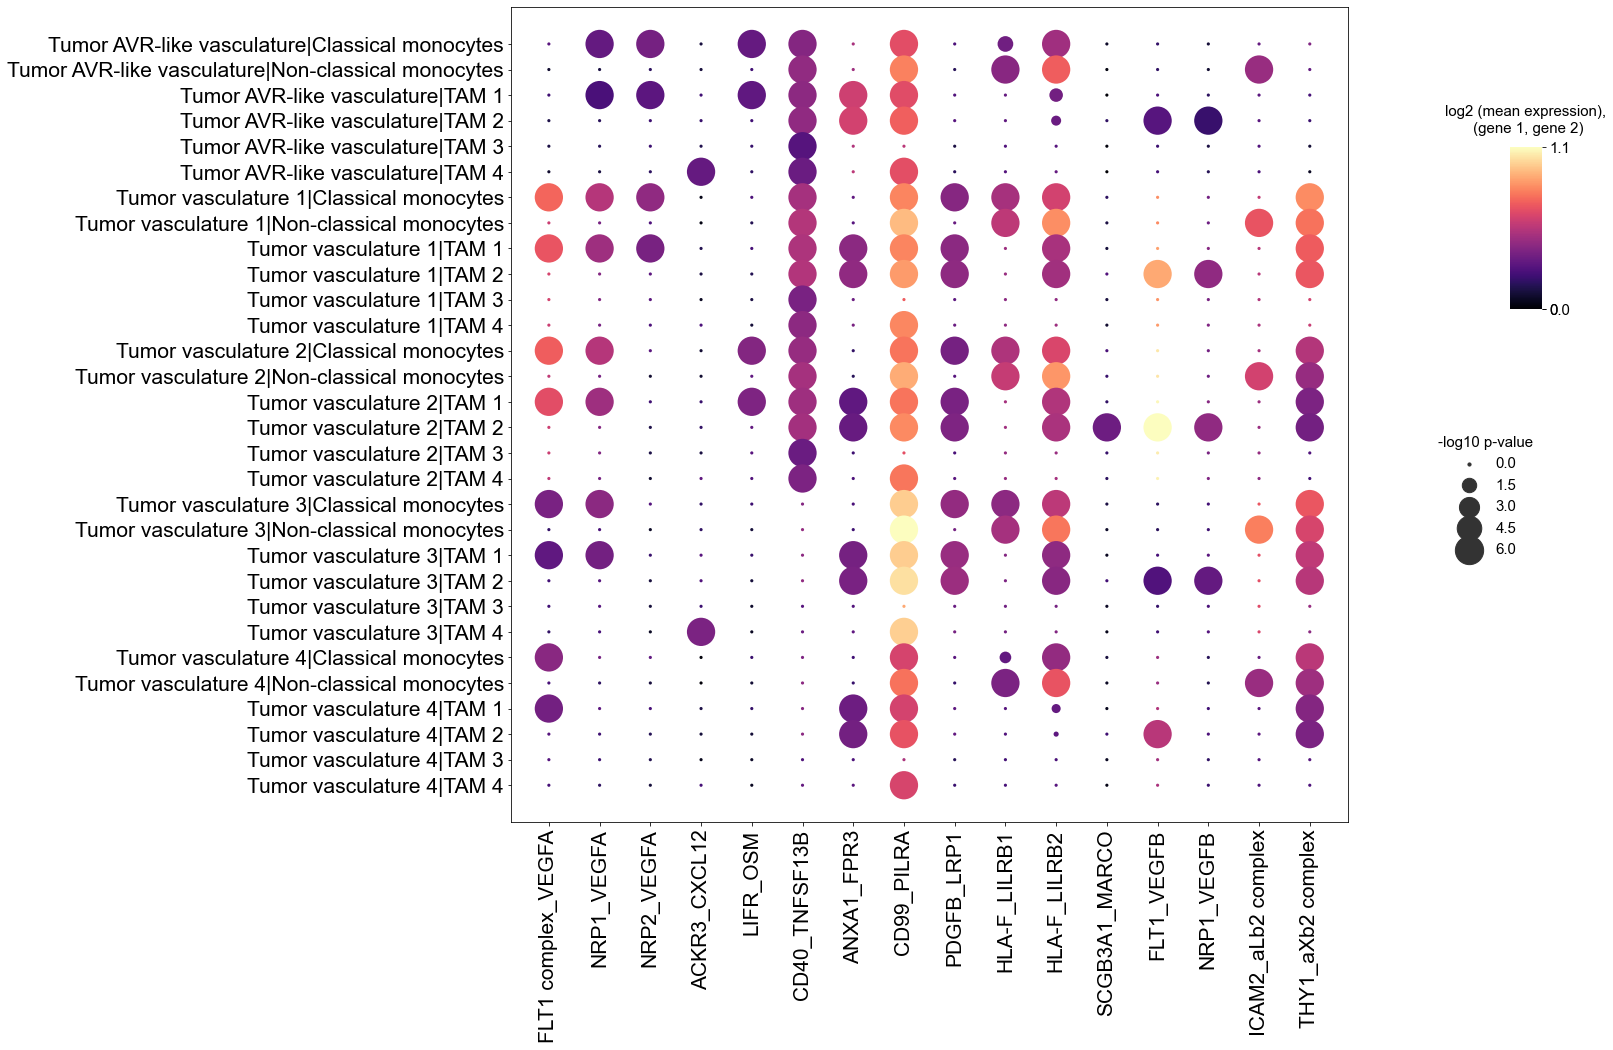

In [44]:
plot_cpdb_dotplot(endo_imm2, figsize=(15, 15))

### Add the shorter labels

In [45]:
new_labels=[]
for i in endo_imm2.pair:
    both = i.split('|')
    pair1 = both[0]
    pair2= both[1]
    if pair1 in renamer.keys():
        pair1=renamer[pair1]
    if pair2 in renamer.keys():
        pair2=renamer[pair2]
    new_label=pair1 + '|' + pair2
    new_labels.append(new_label)
endo_imm2['pair2'] = new_labels
    

<ipython-input-45-e0cef9324d2a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endo_imm2['pair2'] = new_labels


In [46]:
##make it nice!


def plot_cpdb_dotplot_fancy(data, figsize =(20, 4)):
    cmap =sns.color_palette("magma", as_cmap=True)
    mpl.rcParams['axes.grid'] = False
    mpl.rcParams['legend.frameon'] = False
    fig, ax = plt.subplots(figsize=figsize)
    ax1 = sns.scatterplot(x=data.index, y=data['pair2'], 
                size=data['-log10 p-value'],  sizes = (10, 650),
                hue=np.log2(data["mean"]), data=data, palette='magma',  linewidth=0)
    
    ax1.set_facecolor('white')
    ax1.set_frame_on(False)
    #removing the 'pair' labels
    ax1.set(ylabel=None)
    ax1.set(xlabel=None)
    plt.draw()
    #ax1.set_xticks()
    
    
    labelsx = ax1.xaxis.get_ticklabels(which='both')
    labels_redx = [str(i.get_text()).split('_')[0] for i in labelsx]
    labels_blackx = [str(i.get_text()).split('_')[1] for i in labelsx]
    
    labelsy = ax1.yaxis.get_ticklabels(which='both')
    labels_redy = [str(i.get_text()).split('|')[0] for i in labelsy]
    labels_blacky = [str(i.get_text()).split('|')[1] for i in labelsy]
    
    ax1.set_xticklabels([])
    ax1.set_yticklabels(labels_blacky, fontsize=21)
    
    for i in range(len(labels_redx)):
        boxes = [TextArea(text, textprops=dict(color=color, rotation=90, horizontalalignment='right', fontsize=21))
                   for text, color in zip([labels_redx[i], '--', labels_blackx[i]][::-1], ['black', 'grey', 'purple'])]
        xbox = VPacker(children=boxes, align="right", pad=0, sep=0)
        anchored_xbox = AnchoredOffsetbox(loc='upper right', child=xbox, pad=0, frameon=False, bbox_to_anchor=(i+1.2, len(labels_blacky)),
                                       bbox_transform=ax1.transData, borderpad=0)
        ax1.add_artist(anchored_xbox)
    
    #using part of legend for accurate legend dot sizes
    h,l = ax1.get_legend_handles_labels()
    index_of_label = []
    for i, label in enumerate(l):
        if label=='-log10 p-value':
            index_of_label.append(i)
            new_label = round(float(l[i+1]), 2)
            l[i+1] = new_label
           
            
    ax1.legend(h[index_of_label[0]+1:], l[index_of_label[0]+1:], 
               bbox_to_anchor=(1.14,0.4), loc="center left", borderaxespad=0, 
               fontsize=15,
              title = '-log10 p-value', title_fontsize=15, labelspacing =0.7, 
              markerscale=0.9)
    
    #get max and min values for colorbar
    vmax = round(np.percentile(max(np.log2(data["mean"])), 99), 1)
    vmin = round(min(np.log2(data['mean'])), 1)
    norm = mpl.colors.Normalize(0, vmax)
   
   # # colorbar
    caxb = fig.add_axes([1.05, 0.6, 0.03, 0.15])
    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=caxb, orientation='vertical')
    cbar.outline.set_visible(False)
    c = [vmin, 0,  vmax]
    cbar.set_ticks(c)
    cbar.ax.set_yticklabels(c, fontsize = 15)
    cbar.ax.set_title('log2 (mean expression),\n (gene 1, gene 2)', fontsize=15, pad = 15)
    
 
    #Add the lines for interacting cell types
    x,y = np.array([[-11, -11, -11], [-0.2, 5.4, 5.6]])
    line1 = Line2D(x, y, lw=2., color='grey')
    x1,y1 = np.array([[-11, -11, -11], [5.8,11.4, 11.6]])
    line2 = Line2D(x1, y1, lw=2., color='grey')
    x2,y2 = np.array([[-11, -11, -11], [11.8, 17.4, 17.6]])
    line3 = Line2D(x2, y2, lw=2., color='grey')
    x3,y3 = np.array([[-11, -11, -11], [17.8, 23.4, 23.6]])
    line4 = Line2D(x3, y3, lw=2., color='grey')
    x4,y4 = np.array([[-11, -11, -11], [23.8, 29.4, 29.4]])
    line5 = Line2D(x4, y4, lw=2., color='grey')
    #x5,y5 = np.array([[-10, -10, -10], [23.6, 28, 28.2]])
    #line6 = Line2D(x5, y5, lw=2., color='grey')
    #x6,y6 = np.array([[-10, -10, -10], [28.6, 32, 32.2]])
    #line7 = Line2D(x6, y6, lw=2., color='grey')
    #x7,y7 = np.array([[-10, -10, -10], [32.6, 36.2, 36.4]])
    #line8 = Line2D(x7, y7, lw=2., color='grey')
    line1.set_clip_on(False)
    line2.set_clip_on(False)
    line3.set_clip_on(False)
    line4.set_clip_on(False)
    line5.set_clip_on(False)
    #line6.set_clip_on(False)
    #line7.set_clip_on(False)
    #line8.set_clip_on(False)
    ax1.add_line(line1)
    ax1.add_line(line2)
    ax1.add_line(line3)
    ax1.add_line(line4)
    ax1.add_line(line5)
   # ax1.add_line(line6)
   # ax1.add_line(line7)
   # ax1.add_line(line8)
    ax1.text(-22.2, 3.0, 'AVR-like TV', color = 'purple', fontsize=21)
    ax1.text(-19.8, 9, 'TV 1', color = 'purple', fontsize=21)
    ax1.text(-19.8, 15, 'TV 2', color = 'purple', fontsize=21)
    ax1.text(-19.8, 21, 'TV 3', color = 'purple', fontsize=21)
    ax1.text(-19.8, 27, 'TV 4', color = 'purple', fontsize=21)
    #ax1.text(-12.5, 26, 'TAM 2', color = 'purple', fontsize=21)
    #ax1.text(-12.5, 30.5, 'TAM 3', color = 'purple', fontsize=21)
    #ax1.text(-12.5, 34.8, 'TAM 4', color = 'purple', fontsize=21)
    plt.setp(ax.get_xticklabels(), rotation=90)
    
    

    plt.savefig('figures_paper/endo_imm_int.pdf', dpi=600, bbox_inches='tight')
    plt.show()

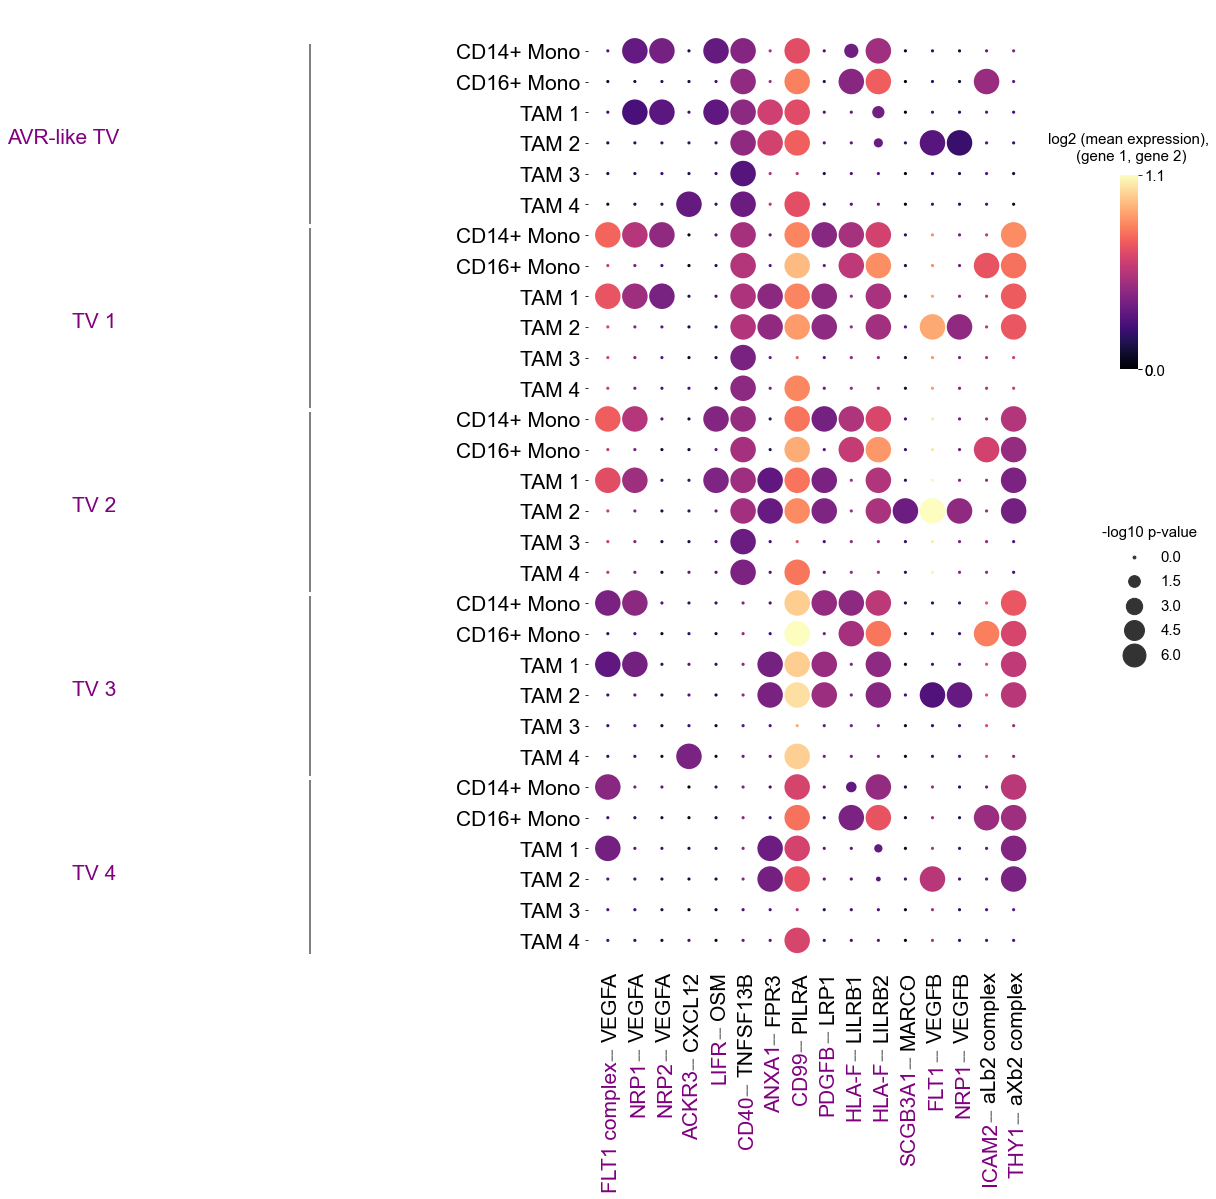

In [47]:
plot_cpdb_dotplot_fancy(endo_imm2, figsize=(8, 18))

### Tumor - immune interactions (and vice versa)

In [48]:
path_int = 'cellphone_output/imm_tum_both_plot.csv'
tumor_imm = pd.read_csv(path_int, header=0, index_col=0)
tumor_imm

pvalue   mean                                  pair  \
interacting_pair                                                        
SPP1_CD44            1.0  1.060             CD8 T cells|Tumor cells 1   
SPP1_CD44            1.0  1.042             CD8 T cells|Tumor cells 2   
SPP1_CD44            1.0  1.046             CD8 T cells|Tumor cells 3   
SPP1_CD44            1.0  1.129     Classical monocytes|Tumor cells 1   
SPP1_CD44            1.0  1.111     Classical monocytes|Tumor cells 2   
...                  ...    ...                                   ...   
NRP2_VEGFA           1.0  1.016  Tumor cells 3|Resting/memory T cells   
NRP2_VEGFA           1.0  1.137                   Tumor cells 3|TAM 1   
NRP2_VEGFA           1.0  1.065                   Tumor cells 3|TAM 2   
NRP2_VEGFA           1.0  1.060                   Tumor cells 3|TAM 3   
NRP2_VEGFA           1.0  1.028                   Tumor cells 3|TAM 4   

                  -log10 p-value partner_a partner_b               type_a  \
interacting_pair                                                            
SPP1_CD44          -4.342943e-07      SPP1      CD44          CD8 T cells   
SPP1_CD44          -4.342943e-07      SPP1      CD44          CD8 T cells   
SPP1_CD44          -4.342943e-07      SPP1      CD44          CD8 T cells   
SPP1_CD44          -4.342943e-07      SPP1      CD44  Classical monocytes   
SPP1_CD44          -4.342943e-07      SPP1      CD44  Classical monocytes   
...                          ...       ...       ...                  ...   
NRP2_VEGFA         -4.342943e-07      NRP2     VEGFA        Tumor cells 3   
NRP2_VEGFA         -4.342943e-07      NRP2     VEGFA        Tumor cells 3   
NRP2_VEGFA         -4.342943e-07      NRP2     VEGFA        Tumor cells 3   
NRP2_VEGFA         -4.342943e-07      NRP2     VEGFA        Tumor cells 3   
NRP2_VEGFA         -4.342943e-07      NRP2     VEGFA        Tumor cells 3   

                                  type_b  
interacting_pair                          
SPP1_CD44                  Tumor cells 1  
SPP1_CD44                  Tumor cells 2  
SPP1_CD44                  Tumor cells 3  
SPP1_CD44                  Tumor cells 1  
SPP1_CD44                  Tumor cells 2  
...                                  ...  
NRP2_VEGFA        Resting/memory T cells  
NRP2_VEGFA                         TAM 1  
NRP2_VEGFA                         TAM 2  
NRP2_VEGFA                         TAM 3  
NRP2_VEGFA                         TAM 4  

[1716 rows x 8 columns]

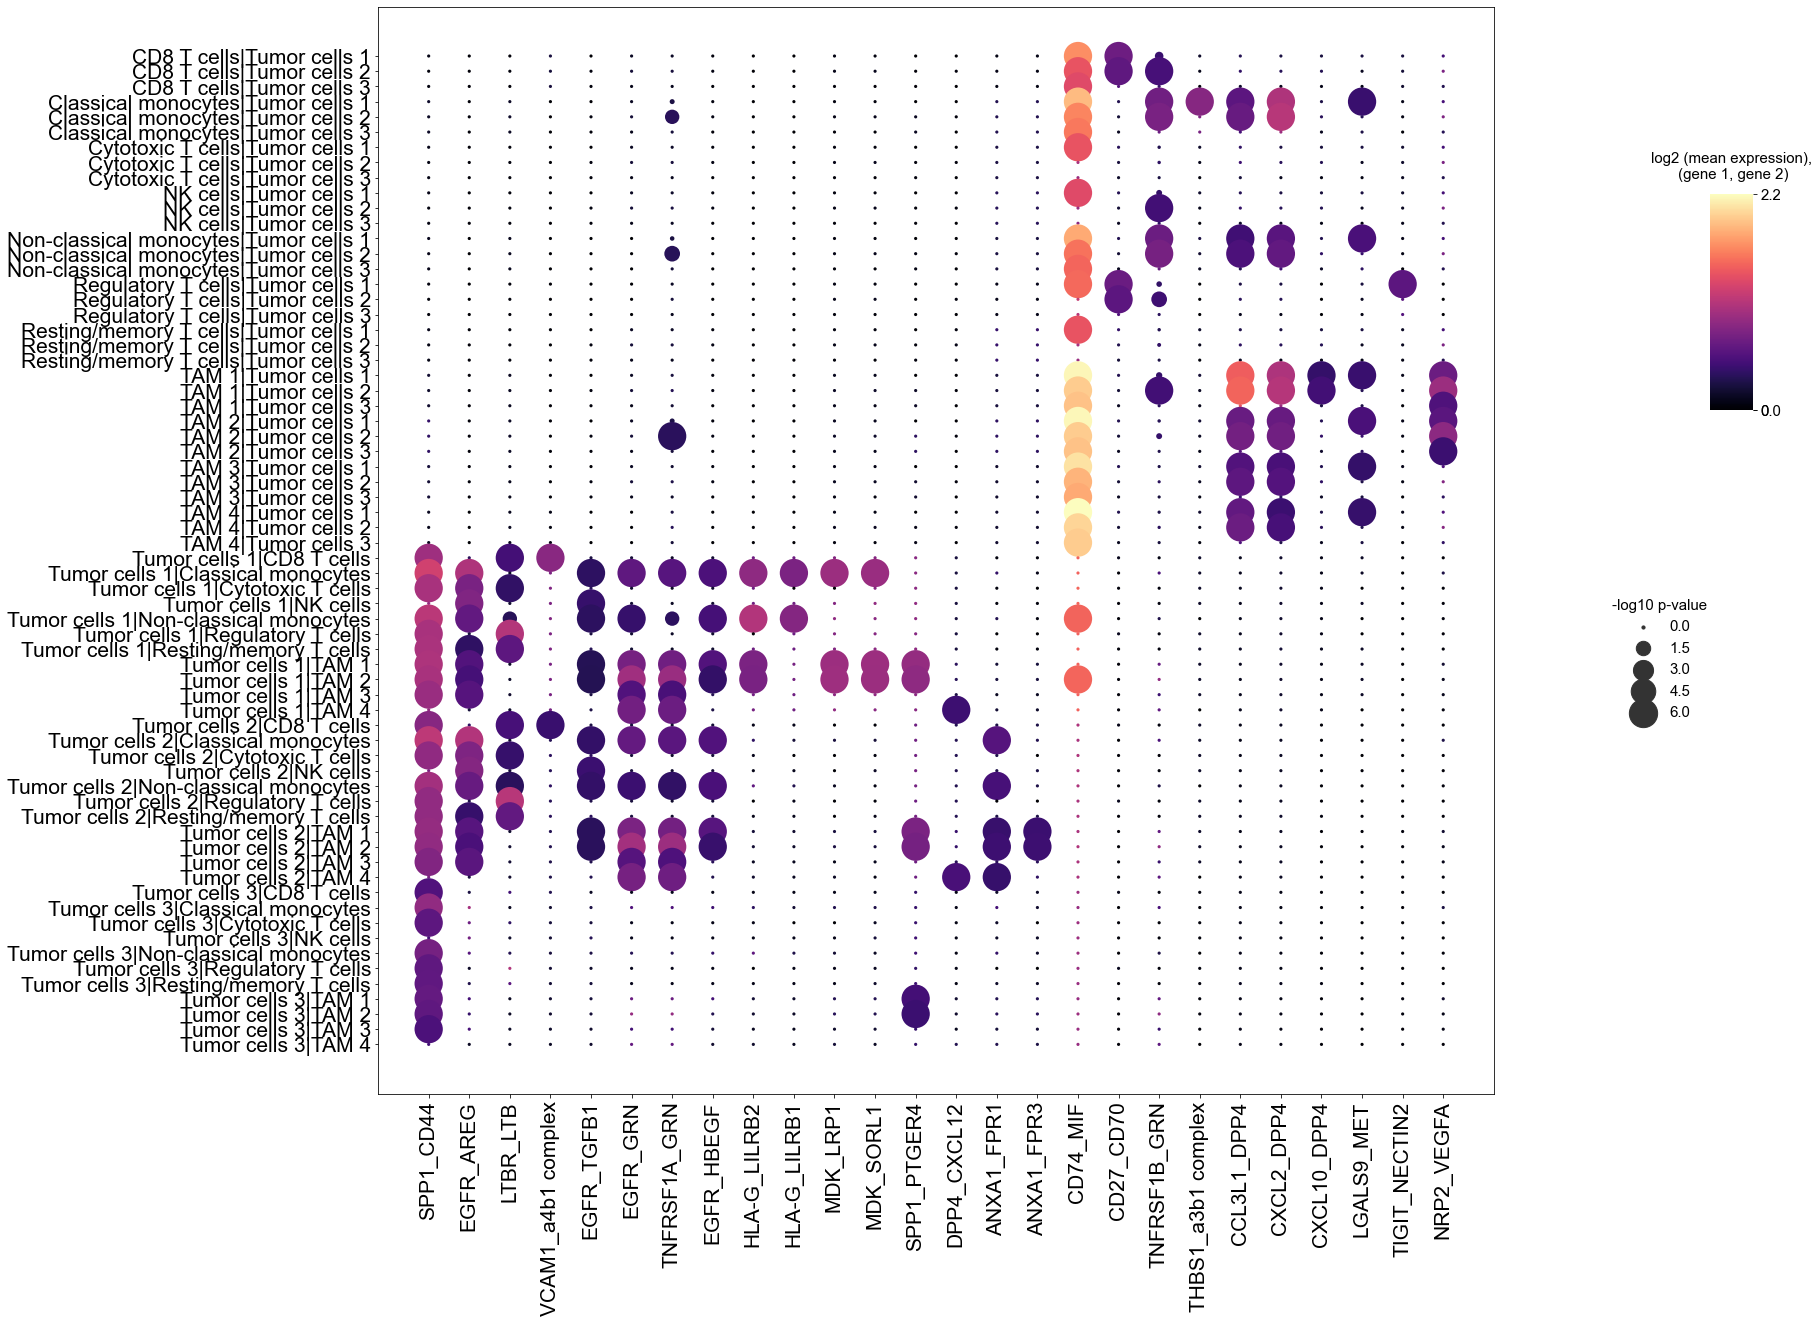

In [49]:
plot_cpdb_dotplot(tumor_imm, figsize=(20, 20))

In [50]:
set(tumor_imm.index)

{'ANXA1_FPR1',
 'ANXA1_FPR3',
 'CCL3L1_DPP4',
 'CD27_CD70',
 'CD74_MIF',
 'CXCL10_DPP4',
 'CXCL2_DPP4',
 'DPP4_CXCL12',
 'EGFR_AREG',
 'EGFR_GRN',
 'EGFR_HBEGF',
 'EGFR_TGFB1',
 'HLA-G_LILRB1',
 'HLA-G_LILRB2',
 'LGALS9_MET',
 'LTBR_LTB',
 'MDK_LRP1',
 'MDK_SORL1',
 'NRP2_VEGFA',
 'SPP1_CD44',
 'SPP1_PTGER4',
 'THBS1_a3b1 complex',
 'TIGIT_NECTIN2',
 'TNFRSF1A_GRN',
 'TNFRSF1B_GRN',
 'VCAM1_a4b1 complex'}

In [51]:
int_pairs = [
      #chemokine proccessing
    'CCL3L1_DPP4',
    'CXCL10_DPP4',
    'CXCL2_DPP4',
    #immune suppression
    'LGALS9_MET',
    'CD27_CD70',
    'TIGIT_NECTIN2',
    'TNFRSF1B_GRN',
    'TNFRSF1A_GRN',
    'ANXA1_FPR1',
    'ANXA1_FPR3',
    'HLA-G_LILRB1',
    'HLA-G_LILRB2',
    'MDK_LRP1',
    'MDK_SORL1',
    'LTBR_LTB',
    'SPP1_CD44',
    'SPP1_PTGER4',
    
    


 #'CD74_MIF',
 
 #'DPP4_CXCL12',
    
 #survival
 'EGFR_AREG',
 'EGFR_GRN',
 'EGFR_HBEGF',
 'EGFR_TGFB1',

 
 
 
 #'NRP2_VEGFA',
 #adhesion
 
 'THBS1_a3b1 complex',
 'VCAM1_a4b1 complex'
    
]

In [52]:
tumor_imm_filt =tumor_imm.loc[int_pairs]

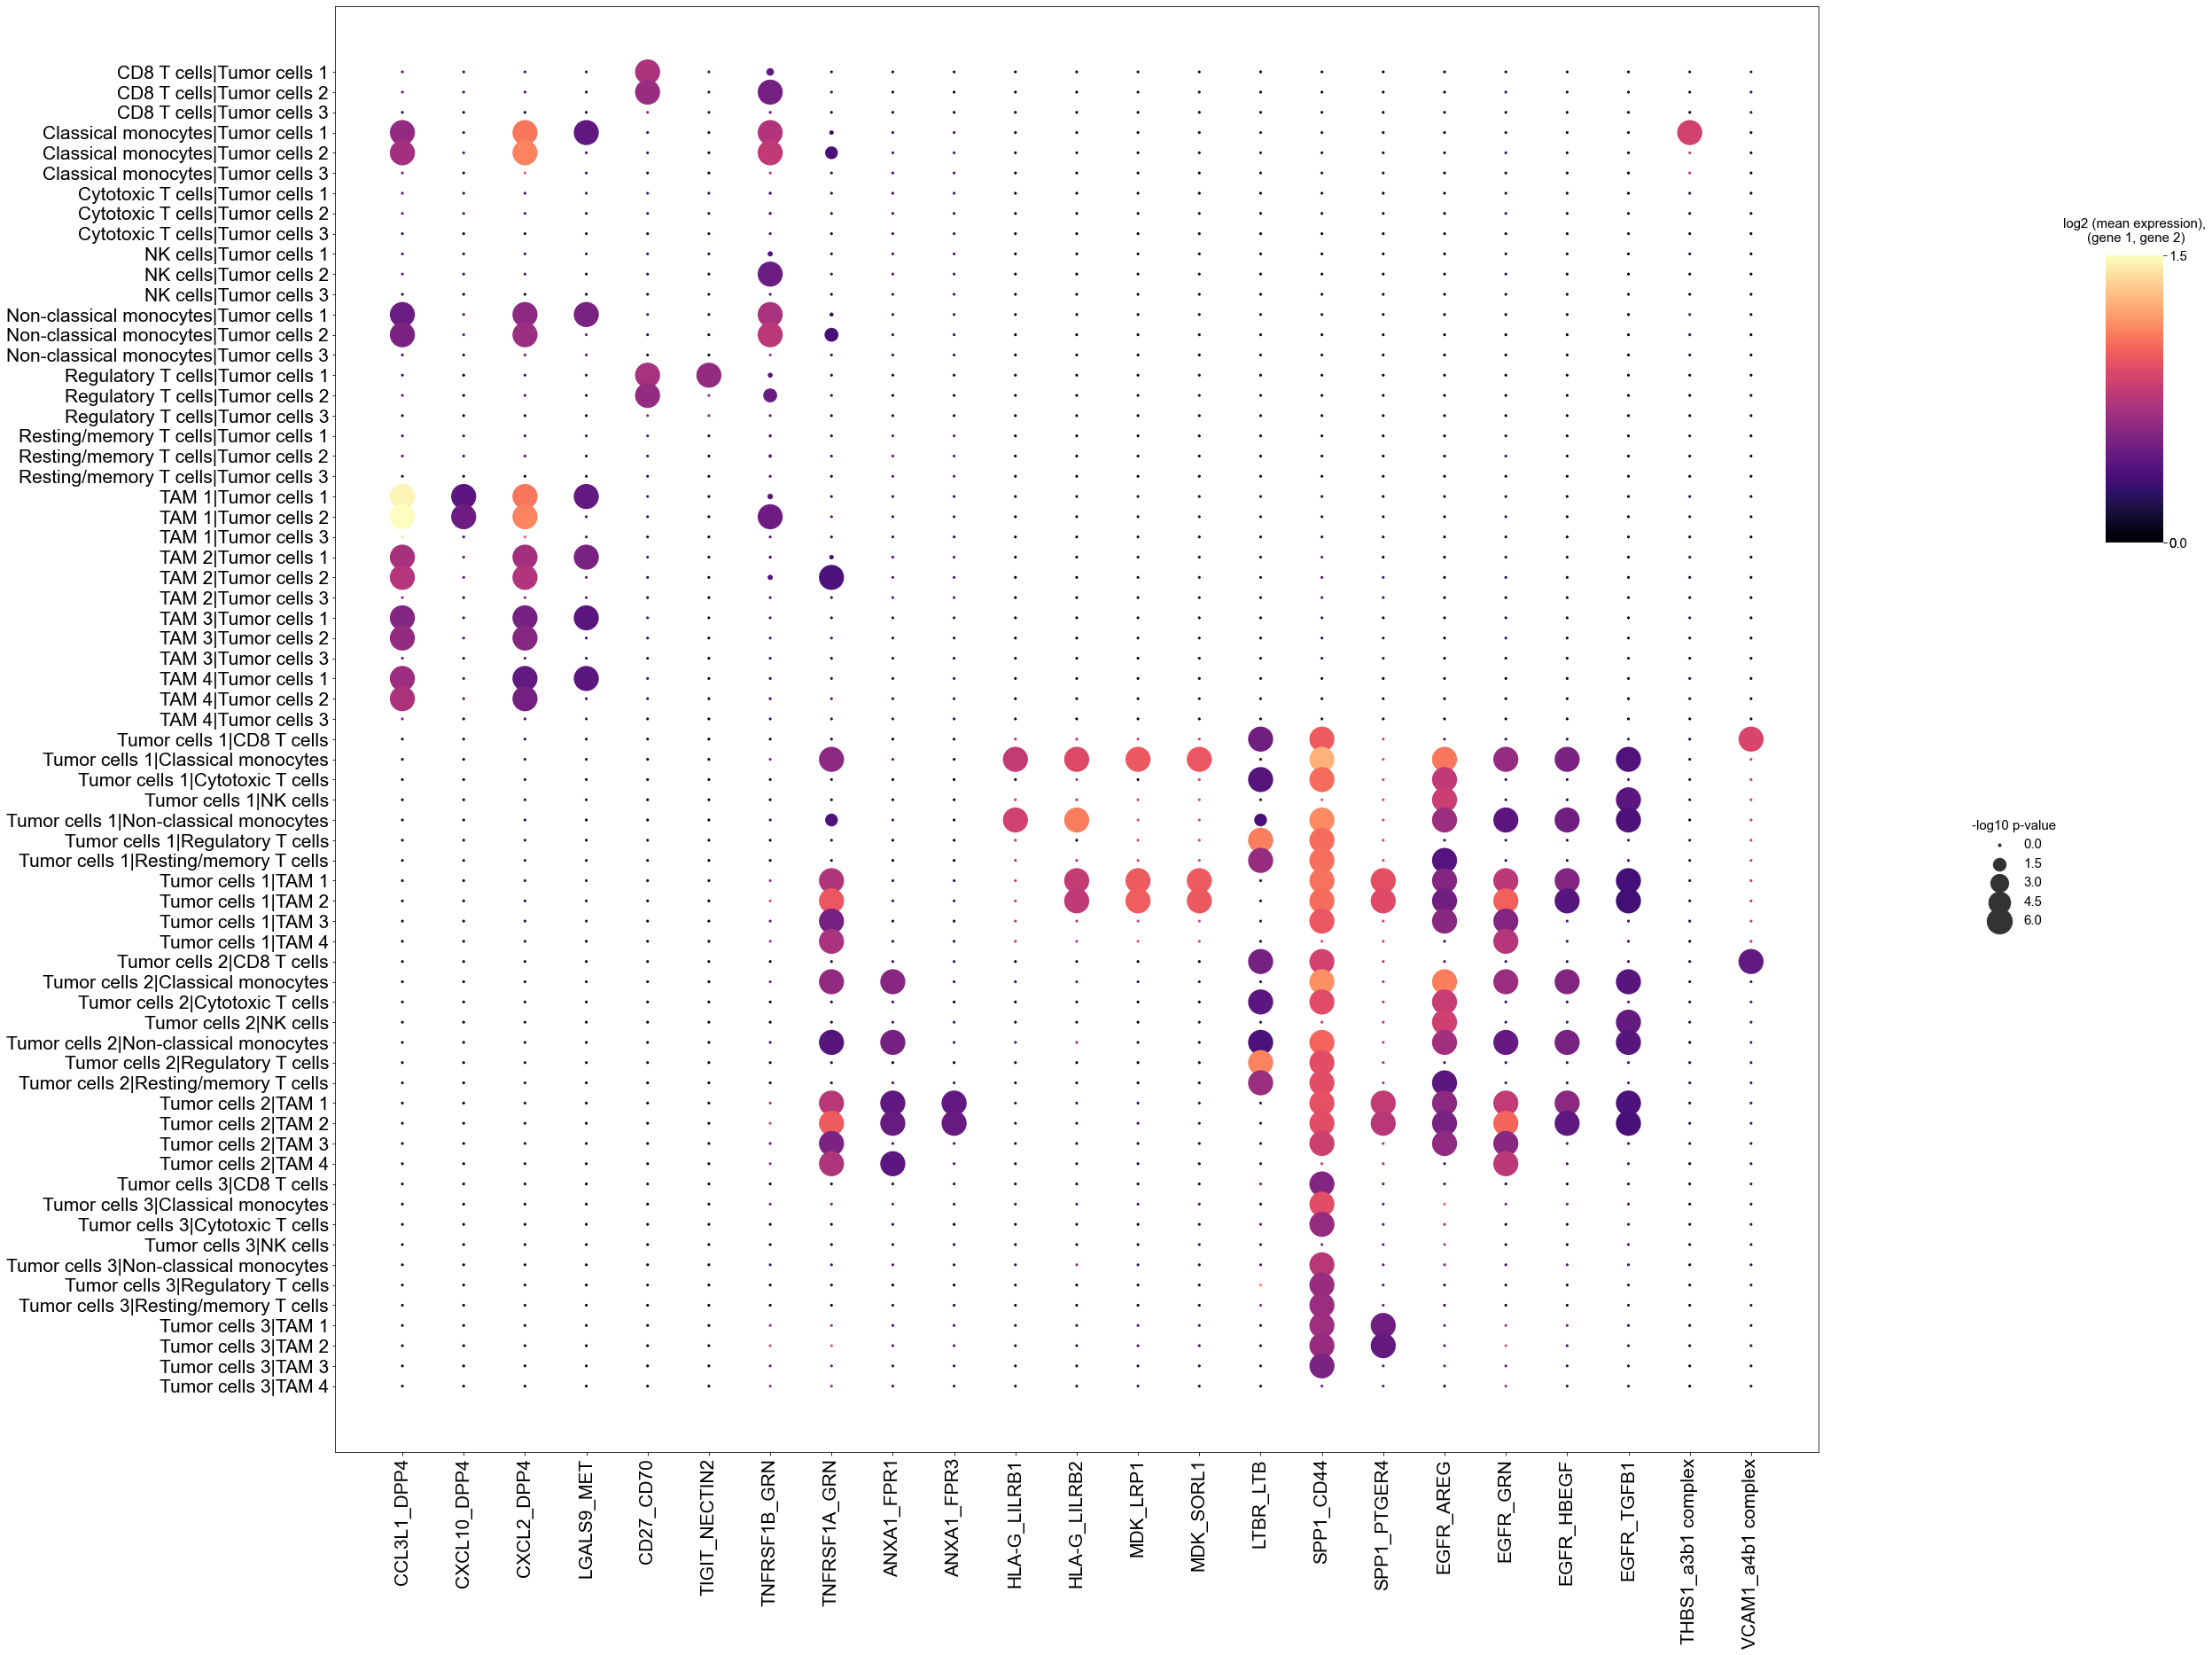

In [53]:
plot_cpdb_dotplot(tumor_imm_filt, figsize= (30, 30))

In [54]:
tumor_imm_filt['pair'].unique()

array(['CD8 T cells|Tumor cells 1', 'CD8 T cells|Tumor cells 2',
       'CD8 T cells|Tumor cells 3', 'Classical monocytes|Tumor cells 1',
       'Classical monocytes|Tumor cells 2',
       'Classical monocytes|Tumor cells 3',
       'Cytotoxic T cells|Tumor cells 1',
       'Cytotoxic T cells|Tumor cells 2',
       'Cytotoxic T cells|Tumor cells 3', 'NK cells|Tumor cells 1',
       'NK cells|Tumor cells 2', 'NK cells|Tumor cells 3',
       'Non-classical monocytes|Tumor cells 1',
       'Non-classical monocytes|Tumor cells 2',
       'Non-classical monocytes|Tumor cells 3',
       'Regulatory T cells|Tumor cells 1',
       'Regulatory T cells|Tumor cells 2',
       'Regulatory T cells|Tumor cells 3',
       'Resting/memory T cells|Tumor cells 1',
       'Resting/memory T cells|Tumor cells 2',
       'Resting/memory T cells|Tumor cells 3', 'TAM 1|Tumor cells 1',
       'TAM 1|Tumor cells 2', 'TAM 1|Tumor cells 3',
       'TAM 2|Tumor cells 1', 'TAM 2|Tumor cells 2',
       'TAM 2|Tumor 

In [55]:
#removing empty lines
#removing some pairs that have no significant interactions
mask_int=~tumor_imm_filt['pair'].isin(['CD8 T cells|Tumor cells 3', 'Classical monocytes|Tumor cells 3',
                                       'Cytotoxic T cells|Tumor cells 1',
       'Cytotoxic T cells|Tumor cells 2',
       'Cytotoxic T cells|Tumor cells 3', 'NK cells|Tumor cells 1',
       'NK cells|Tumor cells 2', 'NK cells|Tumor cells 3',  'Non-classical monocytes|Tumor cells 3',
                                       'Regulatory T cells|Tumor cells 3','Resting/memory T cells|Tumor cells 1',
       'Resting/memory T cells|Tumor cells 2',
       'Resting/memory T cells|Tumor cells 3', 'TAM 1|Tumor cells 3', 'TAM 2|Tumor cells 3', 'TAM 3|Tumor cells 3',
        'TAM 4|Tumor cells 3','Tumor cells 3|Classical monocytes',
       'Tumor cells 3|Cytotoxic T cells', 'Tumor cells 3|NK cells',
       'Tumor cells 3|Non-classical monocytes',
       'Tumor cells 3|Regulatory T cells',
       'Tumor cells 3|Resting/memory T cells', 'Tumor cells 3|TAM 1',
       'Tumor cells 3|TAM 2', 'Tumor cells 3|TAM 3',
       'Tumor cells 3|TAM 4', 'Tumor cells 3|CD8 T cells',

                                 
                                  ])

tumor_imm_filt2=tumor_imm_filt[mask_int]

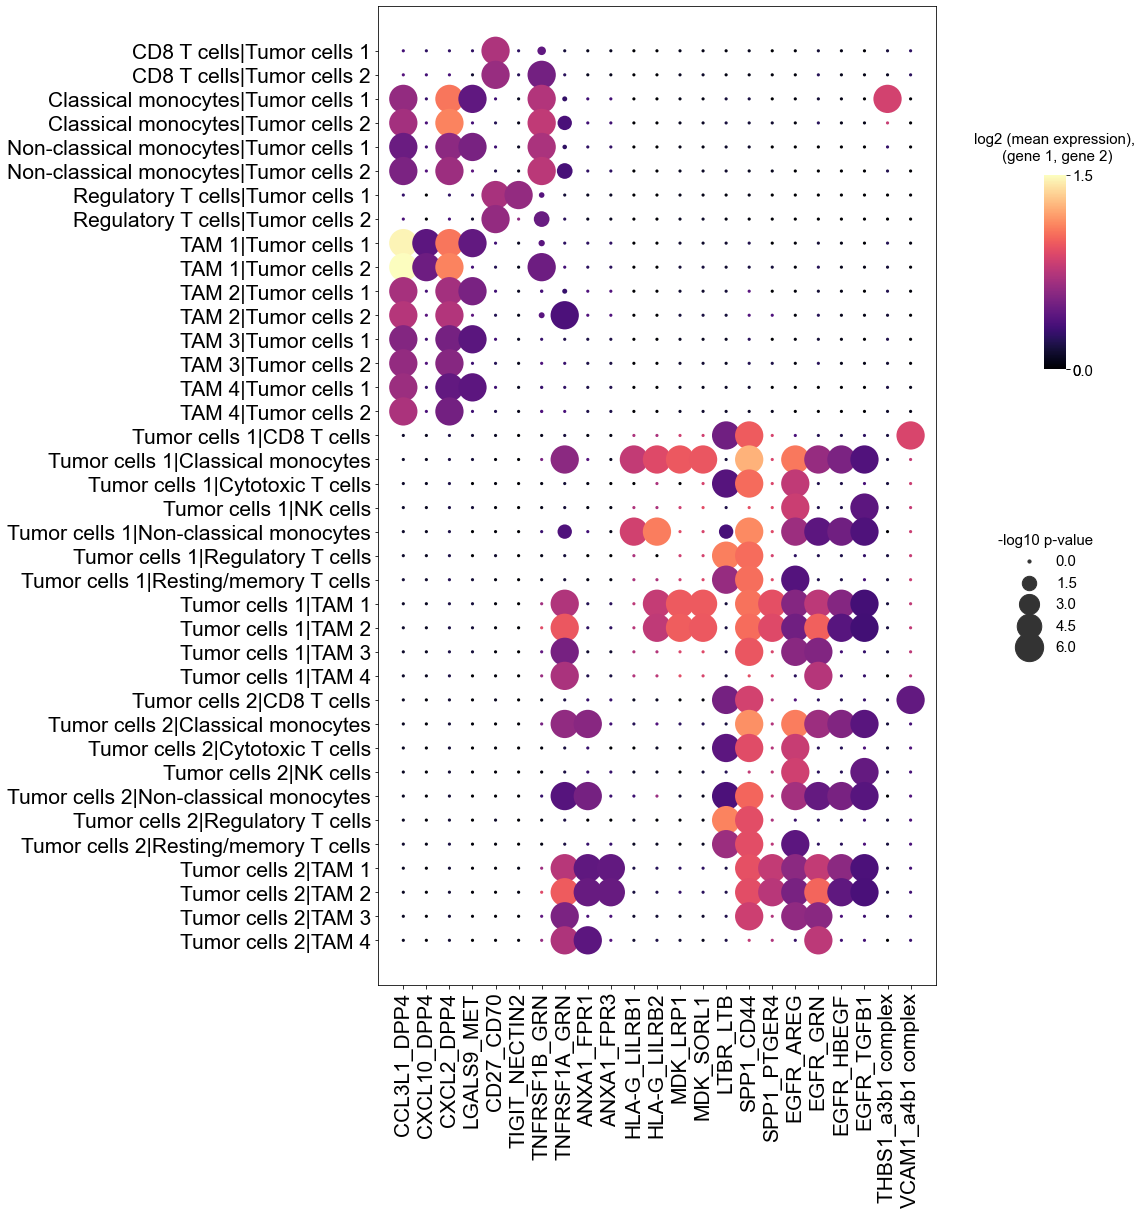

In [56]:
plot_cpdb_dotplot(tumor_imm_filt2, figsize= (10, 18))

### Add alternative labels

In [57]:
new_labels=[]
for i in tumor_imm_filt2.pair:
    both = i.split('|')
    pair1 = both[0]
    pair2= both[1]
    if pair1 in renamer.keys():
        pair1=renamer[pair1]
    if pair2 in renamer.keys():
        pair2=renamer[pair2]
    new_label=pair1 + '|' + pair2
    new_labels.append(new_label)
tumor_imm_filt2['pair2'] = new_labels
    

<ipython-input-57-85246bc03756>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tumor_imm_filt2['pair2'] = new_labels


In [60]:
##make it nice!


def plot_cpdb_dotplot_fancy(data, figsize =(20, 4)):
    cmap =sns.color_palette("magma", as_cmap=True)
    mpl.rcParams['axes.grid'] = False
    mpl.rcParams['legend.frameon'] = False
    fig, ax = plt.subplots(figsize=figsize)
    ax1 = sns.scatterplot(x=data.index, y=data['pair2'], 
                size=data['-log10 p-value'],  sizes = (10, 650),
                hue=np.log2(data["mean"]), data=data, palette='magma',  linewidth=0)
    
    ax1.set_facecolor('white')
    ax1.set_frame_on(False)
    #removing the 'pair' labels
    ax1.set(ylabel=None)
    ax1.set(xlabel=None)
    plt.draw()
    #ax1.set_xticks()
    
    
    labelsx = ax1.xaxis.get_ticklabels(which='both')
    labels_redx = [str(i.get_text()).split('_')[0] for i in labelsx]
    labels_blackx = [str(i.get_text()).split('_')[1] for i in labelsx]
    
    labelsy = ax1.yaxis.get_ticklabels(which='both')
    labels_redy = [str(i.get_text()).split('|')[0] for i in labelsy]
    labels_blacky = [str(i.get_text()).split('|')[1] for i in labelsy]
    
    ax1.set_xticklabels([])
    ax1.set_yticklabels(labels_blacky, fontsize=21)
    
    for i in range(len(labels_redx)):
        boxes = [TextArea(text, textprops=dict(color=color, rotation=90, horizontalalignment='right', fontsize=21))
                   for text, color in zip([labels_redx[i], '--', labels_blackx[i]][::-1], ['black', 'grey', 'purple'])]
        xbox = VPacker(children=boxes, align="right", pad=0, sep=0)
        anchored_xbox = AnchoredOffsetbox(loc='upper right', child=xbox, pad=0, frameon=False, bbox_to_anchor=(i+1.2, len(labels_blacky)),
                                       bbox_transform=ax1.transData, borderpad=0)
        ax1.add_artist(anchored_xbox)
    
    #using part of legend for accurate legend dot sizes
    h,l = ax1.get_legend_handles_labels()
    index_of_label = []
    for i, label in enumerate(l):
        if label=='-log10 p-value':
            index_of_label.append(i)
            new_label = round(float(l[i+1]), 2)
            l[i+1] = new_label
           
            
    ax1.legend(h[index_of_label[0]+1:], l[index_of_label[0]+1:], 
               bbox_to_anchor=(1.14,0.4), loc="center left", borderaxespad=0, 
               fontsize=15,
              title = '-log10 p-value', title_fontsize=15, labelspacing =0.7, 
              markerscale=0.9)
    
    #get max and min values for colorbar
    vmax = round(np.percentile(max(np.log2(data["mean"])), 99), 1)
    vmin = round(min(np.log2(data['mean'])), 1)
    norm = mpl.colors.Normalize(0, vmax)
   
   # # colorbar
    caxb = fig.add_axes([1.05, 0.6, 0.03, 0.15])
    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=caxb, orientation='vertical')
    cbar.outline.set_visible(False)
    c = [vmin, 0,  vmax]
    cbar.set_ticks(c)
    cbar.ax.set_yticklabels(c, fontsize = 15)
    cbar.ax.set_title('log2 (mean expression),\n (gene 1, gene 2)', fontsize=15, pad = 15)
    
 
    #Add the lines for interacting cell types
    x,y = np.array([[-7.5, -7.5, -7.5], [-0.2, 1.2, 1.4]])
    line1 = Line2D(x, y, lw=2., color='grey')
    x1,y1 = np.array([[-7.5, -7.5, -7.5], [1.8,3.2, 3.4]])
    line2 = Line2D(x1, y1, lw=2., color='grey')
    x2,y2 = np.array([[-7.5, -7.5, -7.5], [3.8, 5.2, 5.4]])
    line3 = Line2D(x2, y2, lw=2., color='grey')
    x3,y3 = np.array([[-7.5, -7.5, -7.5], [5.8, 7.2, 7.4]])
    line4 = Line2D(x3, y3, lw=2., color='grey')
    x4,y4 = np.array([[-7.5, -7.5, -7.5], [7.8, 9.2, 9.4]])
    line5 = Line2D(x4, y4, lw=2., color='grey')
    x5,y5 = np.array([[-7.5, -7.5, -7.5], [9.8, 11.2, 11.4]])
    line6 = Line2D(x5, y5, lw=2., color='grey')
    x6,y6 = np.array([[-7.5, -7.5, -7.5], [11.8, 13.2, 13.4]])
    line7 = Line2D(x6, y6, lw=2., color='grey')
    x7,y7 = np.array([[-7.5, -7.5, -7.5], [13.8, 15.2, 15.4]])
    line8 = Line2D(x7, y7, lw=2., color='grey')
    x8,y8 = np.array([[-12, -12, -12], [15.8, 26.2, 26.4]])
    line9 = Line2D(x8, y8, lw=2., color='grey')
    x9,y9 = np.array([[-12, -12, -12], [26.8, 37.2, 37.4]])
    line10 = Line2D(x9, y9, lw=2., color='grey')
    line1.set_clip_on(False)
    line2.set_clip_on(False)
    line3.set_clip_on(False)
    line4.set_clip_on(False)
    line5.set_clip_on(False)
    line6.set_clip_on(False)
    line7.set_clip_on(False)
    line8.set_clip_on(False)
    line9.set_clip_on(False)
    line10.set_clip_on(False)
    ax1.add_line(line1)
    ax1.add_line(line2)
    ax1.add_line(line3)
    ax1.add_line(line4)
    ax1.add_line(line5)
    ax1.add_line(line6)
    ax1.add_line(line7)
    ax1.add_line(line8)
    ax1.add_line(line9)
    ax1.add_line(line10)
    ax1.text(-8.5, 0.7, 'CD8 T cells', color = 'purple', fontsize=21, ha='right')
    ax1.text(-8.5, 2.7, 'CD14+ Mono', color = 'purple', fontsize=21, ha='right')
    ax1.text(-8.5, 4.7, 'CD16+ Mono', color = 'purple', fontsize=21, ha='right')
    ax1.text(-8.5, 6.7, 'T reg', color = 'purple', fontsize=21, ha='right')
    ax1.text(-8.5, 8.7, 'TAM 1', color = 'purple', fontsize=21, ha='right')
    ax1.text(-8.5, 10.7, 'TAM 2', color = 'purple', fontsize=21, ha='right')
    ax1.text(-8.5, 12.7, 'TAM 3', color = 'purple', fontsize=21, ha='right')
    ax1.text(-8.5, 14.7, 'TAM 4', color = 'purple', fontsize=21, ha='right')
    ax1.text(-12.5, 21., 'Tumor cells 1', color = 'purple', fontsize=21, ha='right')
    ax1.text(-12.5, 32., 'Tumor cells 2', color = 'purple', fontsize=21, ha='right')
    plt.setp(ax.get_xticklabels(), rotation=90)
    
    

    plt.savefig('figures_paper/tumor_imm_int_hq.pdf', dpi=600, bbox_inches='tight')
    plt.show()

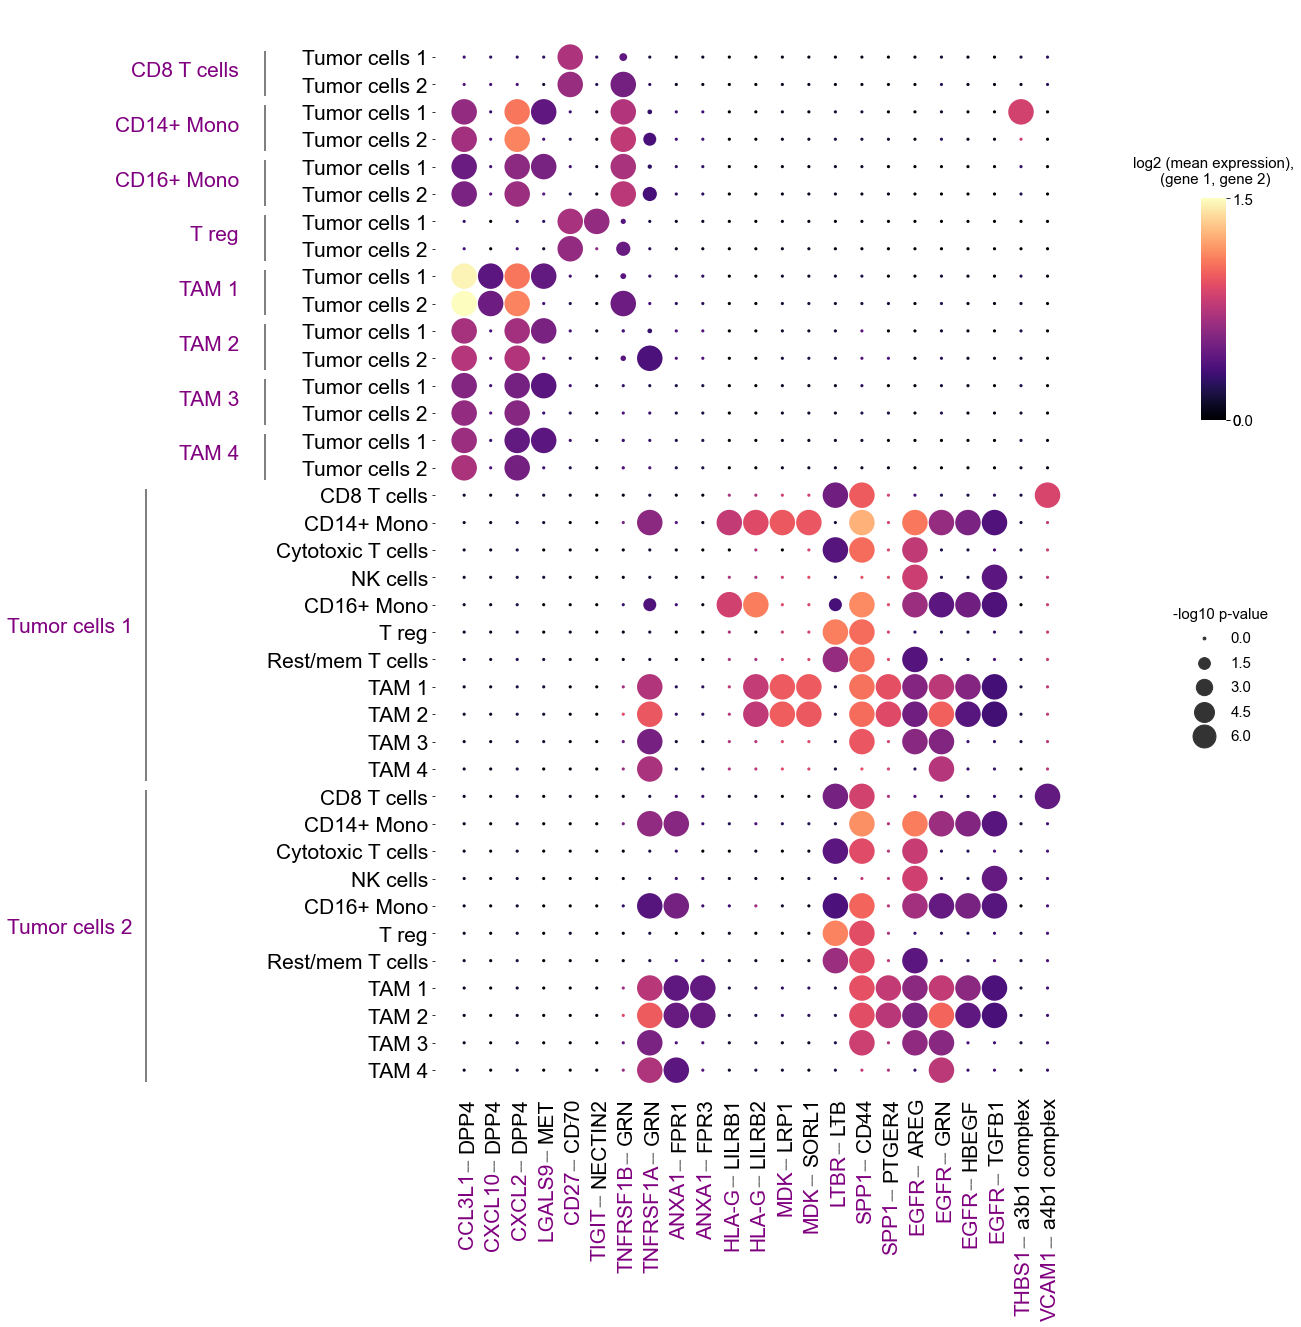

In [61]:
plot_cpdb_dotplot_fancy(tumor_imm_filt2, figsize = (11.5, 20.5))

### Stromal- immune (and vice versa)

In [62]:

path_int = 'cellphone_output/stromal_immune_both_plot.csv'
df_to_plot = pd.read_csv(path_int, header=0, index_col=0)


In [63]:
int_to_remove_mask1 = ~(strom_imm_int['type_a'].isin(['Mesangial/vSMCs'])
                       &strom_imm_int['type_b'].isin(['Regulatory T cells', 'Resting/memory T cells']))

int_to_remove_mask2 = ~(strom_imm_int['type_a'].isin(['vSMCs'])
                       &strom_imm_int['type_b'].isin(['Regulatory T cells', 'Resting/memory T cells', 'Cytotoxic T cells']))

strom_imm2 = strom_imm_int[int_to_remove_mask1&int_to_remove_mask2]

NameError: name 'strom_imm_int' is not defined

### Add alternative labels

In [64]:
new_labels=[]
for i in df_to_plot.pair:
    both = i.split('|')
    pair1 = both[0]
    pair2= both[1]
    if pair1 in renamer.keys():
        pair1=renamer[pair1]
    if pair2 in renamer.keys():
        pair2=renamer[pair2]
    new_label=pair1 + '|' + pair2
    new_labels.append(new_label)
df_to_plot['pair2'] = new_labels
    

In [69]:
#improved plotting function for dotplot


def plot_cpdb_dotplot_fancy(data, figsize =(20, 4)):
    cmap =sns.color_palette("magma", as_cmap=True)
    mpl.rcParams['axes.grid'] = False
    mpl.rcParams['legend.frameon'] = False
    fig, ax = plt.subplots(figsize=figsize)
    ax1 = sns.scatterplot(x=data.index, y=data['pair2'], 
                size=data['-log10 p-value'],  sizes = (10, 650),
                hue=np.log2(data["mean"]), data=data, palette='magma',  linewidth=0)
    
    ax1.set_facecolor('white')
    ax1.set_frame_on(False)
    #removing the 'pair' labels
    ax1.set(ylabel=None)
    ax1.set(xlabel=None)
    plt.draw()
    #ax1.set_xticks()
    
    
    labelsx = ax1.xaxis.get_ticklabels(which='both')
    labels_redx = [str(i.get_text()).split('_')[0] for i in labelsx]
    labels_blackx = [str(i.get_text()).split('_')[1] for i in labelsx]
    
    labelsy = ax1.yaxis.get_ticklabels(which='both')
    labels_redy = [str(i.get_text()).split('|')[0] for i in labelsy]
    labels_blacky = [str(i.get_text()).split('|')[1] for i in labelsy]
    
    ax1.set_xticklabels([])
    ax1.set_yticklabels(labels_blacky, fontsize=21)
    
    for i in range(len(labels_redx)):
        boxes = [TextArea(text, textprops=dict(color=color, rotation=90, horizontalalignment='right', fontsize=21))
                   for text, color in zip([labels_redx[i], '--', labels_blackx[i]][::-1], ['black', 'grey', 'purple'])]
        xbox = VPacker(children=boxes, align="right", pad=0, sep=0)
        anchored_xbox = AnchoredOffsetbox(loc='upper right', child=xbox, pad=0, frameon=False, bbox_to_anchor=(i+0.8, len(labels_blacky)),
                                       bbox_transform=ax1.transData, borderpad=0)
        ax1.add_artist(anchored_xbox)
    
    #using part of legend for accurate legend dot sizes
    h,l = ax1.get_legend_handles_labels()
    index_of_label = []
    for i, label in enumerate(l):
        if label=='-log10 p-value':
            index_of_label.append(i)
            new_label = round(float(l[i+1]), 2)
            l[i+1] = new_label
           
            
    ax1.legend(h[index_of_label[0]+1:], l[index_of_label[0]+1:], 
               bbox_to_anchor=(1.14,0.4), loc="center left", borderaxespad=0, 
               fontsize=15,
              title = '-log10 p-value', title_fontsize=15, labelspacing =0.7, 
              markerscale=0.9)
    
    #get max and min values for colorbar
    vmax = round(np.percentile(max(np.log2(data["mean"])), 99), 1)
    vmin = round(min(np.log2(data['mean'])), 1)
    norm = mpl.colors.Normalize(0, vmax)
   
   # # colorbar
    caxb = fig.add_axes([1.05, 0.6, 0.03, 0.15])
    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=caxb, orientation='vertical')
    cbar.outline.set_visible(False)
    c = [vmin, 0,  vmax]
    cbar.set_ticks(c)
    cbar.ax.set_yticklabels(c, fontsize = 15)
    cbar.ax.set_title('log2 (mean expression),\n (gene 1, gene 2)', fontsize=15, pad = 15)
    
 
    #Add the lines for interacting cell types
    x,y = np.array([[-8, -8, -8], [-0.1, 7.2, 0]])
    line1 = Line2D(x, y, lw=2., color='grey')
    x1,y1 = np.array([[-8, -8, -8], [7.6, 17, 17.2]])
    line2 = Line2D(x1, y1, lw=2., color='grey')
    x2,y2 = np.array([[-8, -8, -8], [17.6, 20, 20.2]])
    line3 = Line2D(x2, y2, lw=2., color='grey')
    x3,y3 = np.array([[-8, -8, -8], [20.6, 23, 23.2]])
    line4 = Line2D(x3, y3, lw=2., color='grey')
    x4,y4 = np.array([[-8, -8, -8], [23.6, 30, 30.2]])
    line5 = Line2D(x4, y4, lw=2., color='grey')
    line1.set_clip_on(False)
    line2.set_clip_on(False)
    line3.set_clip_on(False)
    line4.set_clip_on(False)
    line5.set_clip_on(False)
    ax1.add_line(line1)
    ax1.add_line(line2)
    ax1.add_line(line3)
    ax1.add_line(line4)
    ax1.add_line(line5)
    ax1.text(-13.2, 3.65, 'Mesangial/vSMCs', color = 'purple', fontsize=21)
    ax1.text(-12.2, 12.5, 'Myofibroblasts', color = 'purple', fontsize=21)
    ax1.text(-10.2, 19, 'TAM 1', color = 'purple', fontsize=21)
    ax1.text(-10.2, 22, 'TAM 2', color = 'purple', fontsize=21)
    ax1.text(-10.2, 27, 'vSMCs', color = 'purple', fontsize=21)
    plt.setp(ax.get_xticklabels(), rotation=90)
    
    

    plt.savefig('figures_paper/stromal_immune_hq.pdf', dpi=600, bbox_inches='tight')
    plt.show()

In [71]:
#save once for later

#df_to_plot.to_csv('cellphone_output/stromal_immune_both_plot.csv')

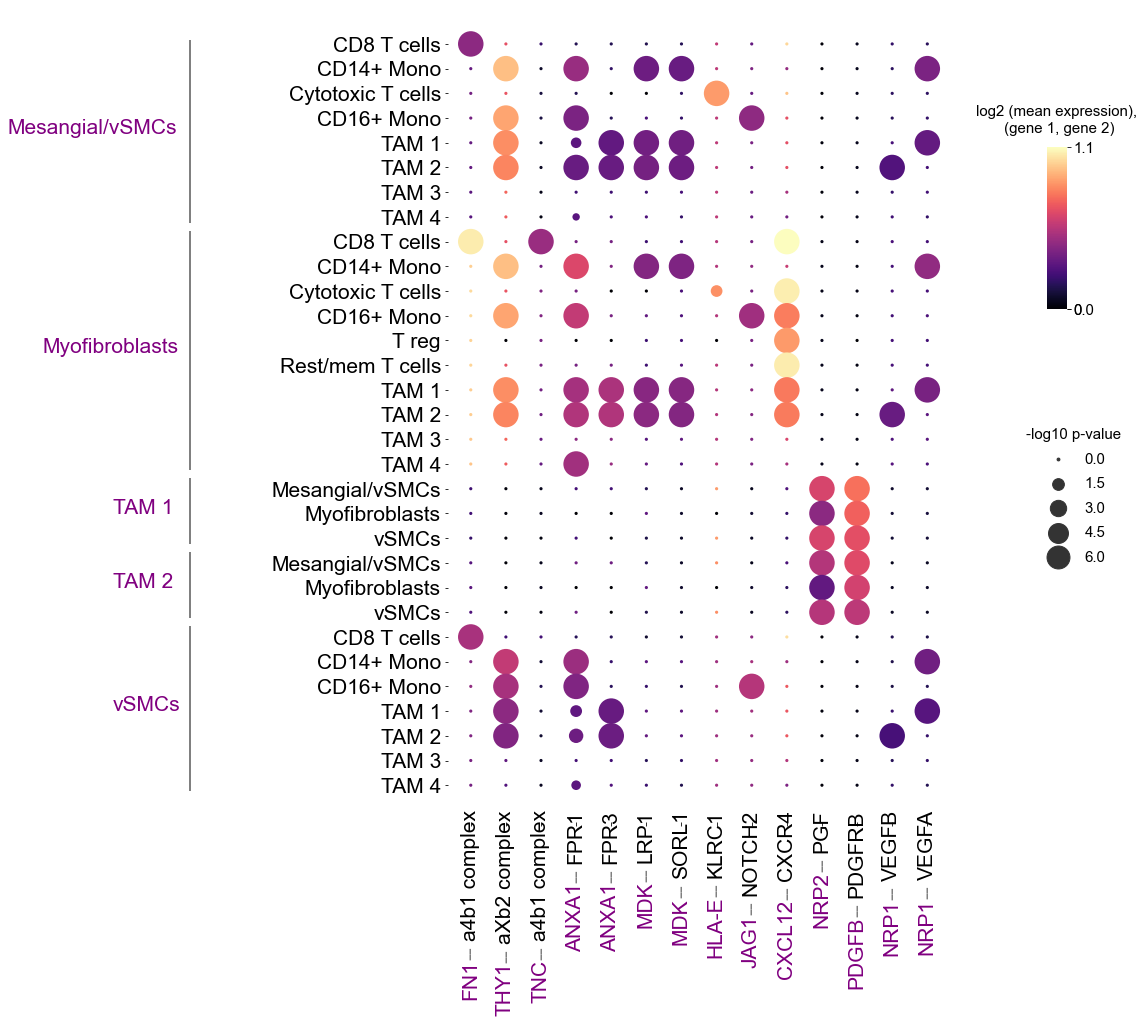

In [72]:
plot_cpdb_dotplot_fancy(df_to_plot,  figsize=(9,15))